In [75]:
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
import keras.backend as K
import datetime
import cv2
 
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from IPython import display
display.clear_output()

In [76]:
# Dùng để liệt kê tất cả các thiết bị có sẵn trên hệ thống mà TensorFlow có thể sử dụng cho tính toán, như CPU và GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import os
print(os.getcwd())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2990092763960646718
xla_global_id: -1
]
C:\One Drive\code\OneDrive - coder7\project\python\l_dl_2024\BT2


# Some Functions

In [77]:
'''
Hàm này tạo ra một tập dữ liệu với hai đặc trưng và một giá trị mục tiêu y được tính theo phân phối chuẩn đa biến.
Tham số:
- n: Số lượng mẫu trong tập dữ liệu.
- r1, r2: Phạm vi của các giá trị x1 và x2.
- m: Vectơ trung bình của phân phối chuẩn đa biến.
- c: Ma trận hiệp phương sai của phân phối chuẩn đa biến.
- export_path: Đường dẫn nơi tập dữ liệu sẽ được lưu sau khi tạo ra.
- verbose: Mức độ chi tiết của thông báo trong quá trình thực hiện.
Quy trình:
- Tạo ra một ma trận x ngẫu nhiên với kích thước (n, 2) (n mẫu, 2 đặc trưng).
- Dựa trên các giá trị r1 và r2, các giá trị trong x sẽ được chuyển đổi về phạm vi tương ứng.
- Tính toán y bằng cách sử dụng phân phối chuẩn đa biến (Gaussian) với trung bình và ma trận hiệp phương sai đã cho.
- Nếu verbose == 1, in thông tin chi tiết về các giá trị min/max và hình dạng của x và y.
- Lưu dữ liệu vào một tệp CSV tại đường dẫn export_path.
Trả về: Một DataFrame chứa dữ liệu x1, x2, và y.
'''
def generate_data(n,  r1= (-2,2), r2= (-4,4), m= np.array([0.0,0.0]), c= np.array([[0.3,-0.5],[-0.5,2]]), export_path="BT2/data/train.csv", verbose = 1):
    
    # generate data
    x = np.random.rand(n, 2)
    x[:, 0] = x[:, 0] * (r1[1] - r1[0]) + r1[0]
    x[:, 1] = x[:, 1] * (r2[1] - r2[0]) + r2[0]

    # calculate gaussian
    y = multivariate_normal.pdf(x, mean = m, cov=c)

    # debug
    if verbose == 1:
        print("x1: ", np.min(x[:, 0]), np.max(x[:, 0]))
        print("x2: ", np.min(x[:, 1]), np.max(x[:, 1]))
        print("x shape: ", x.shape)
        print("y: ", np.min(y), np.max(y))
        print("y shape: ", y.shape)
    # if

    # save data
    db_table = dict(
        data = {"x1": x[:, 0], "x2": x[:, 1], "y": y},
        columns = ["x1", "x2", "y"]
    )

    ds_data = pd.DataFrame(**db_table)

    save_dir = os.path.dirname(export_path)
    if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
    ds_data.to_csv(export_path, index=False)
    
    return ds_data
# generate_dataset 

def load_data(csv_file):
    df_data  = pd.read_csv(csv_file)
    return df_data[["x1", "x2"]].values, df_data[["y"]].values.flatten()
# load_data
def load_dataset(csv_train = "./data/train.csv",
                 csv_valid = "./data/valid.csv",
                 csv_test  = "./data/test.csv"):
    # test
    x_test, y_test = load_data(csv_test)
    
    #train
    x_train, y_train = load_data(csv_train)
    
    #valid
    x_valid, y_valid = load_data(csv_valid)

    return x_train, y_train, x_valid, y_valid, x_test, y_test
# load_dataset

def visualize_dataset(x, y, color = "green", title = "Training Data\n", ax = None):
    if ax is None:
        plt.figure(figsize=(16, 6))
        ax = plt.subplot(1,2,1, projection='3d')
    # if

    surf = ax.scatter(x[:,0], x[:,1], y, c = color)
    ax.set_frame_on
    ax.set_xlabel('x1', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_ylabel('x2', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_zlabel("y", labelpad = 5, fontdict=dict(fontsize = 14))
    plt.legend(['Gaussian values'])
    plt.title(title, fontdict=dict(fontsize = 20))
# visualize_dataset

def normalize_data(x_train, x_valid, x_test):
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", 
                                                                      csv_valid="./data/valid.csv", 
                                                                      csv_test="./data/test.csv")
    v_mean, v_std = None, None
    
    # Visualize data
    print("*******************")
    print("Befor Normalization")
    print("*******************")
    print("Train min=%.3f, max=%.3f" % (x_train.min(), x_train.max()))
    print("Valid min=%.3f, max=%.3f" % (x_valid.min(), x_valid.max()))
    print("Test min=%.3f, max=%.3f" % (x_test.min(), x_test.max()))
    
    # Visualize data
    if v_mean is None and v_std is None: # Prevent normalization with many times
        v_mean = np.mean(x_train, axis = 0)
        v_std  = np.std(x_train, axis = 0)

        x_train = (x_train - v_mean) / v_std
        x_valid = (x_valid - v_mean) / v_std
        x_test  = (x_test - v_mean) / v_std
    # if
    print("\n\n")
    print("Mean = %s, Std = %s"%(str(v_mean), str(v_std)))
    
    print("*******************")
    print("After Normalization")
    print("*******************")    
    print("Train min=%.3f, max=%.3f" % (x_train.min(), x_train.max()))
    print("Valid min=%.3f, max=%.3f" % (x_valid.min(), x_valid.max()))
    print("Test min=%.3f, max=%.3f" % (x_test.min(), x_test.max()))
    
    return x_train, x_valid, x_test
# build_data

def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title("Mean Squared Error")
    plt.plot(history.history["loss"], color="blue", label="train")
    plt.plot(history.history['val_loss'], color="orange", label='test')
# summarize_diagnostics

# Dùng để trực quan hóa các thông tin từ quá trình huấn luyện và kiểm tra mô hình, chẳng hạn như độ lỗi và hàm mất mát (loss) theo từng epoch
def visualize_logs(visualize_data, group_data, figsize = (10, 5), is_show = True, label_size = 12, title_size = 16, save_path = None):
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt, numpy as np
    
    fig = plt.figure(figsize=figsize)
    for idx, group in enumerate(group_data):
        x_axis_name, y_axis_names, title, style = group["x"], group["y"], group["title"], group["style"]
        x_values = visualize_data[x_axis_name]
        end_logs = dict([(x_axis_name, x_values[-1])])

        ax = plt.subplot(1, len(group_data), idx%len(group_data) + 1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        for y_axis_name in y_axis_names:
            y_values = visualize_data[y_axis_name]
            if style is not None and style != "":
                y_values = []
                for i in range(len(visualize_data[y_axis_name])):
                    if style == "median":
                        y_values.append(np.median(visualize_data[y_axis_name][:i+1]))
                    elif style == "avg":
                        y_values.append(np.average(visualize_data[y_axis_name][:i+1]))
                    elif style == "max":
                        y_values.append(np.max(visualize_data[y_axis_name][:i+1]))
                    elif style == "min":
                        y_values.append(np.min(visualize_data[y_axis_name][:i+1]))
            # if
            end_logs.update(dict([(y_axis_name, y_values[-1])]))
            ax.plot(x_values, y_values)
        pass
        title = title.format(**end_logs)

        ax.set_xlabel(x_axis_name, fontsize = label_size)
        ax.legend(y_axis_names, loc='upper left', fontsize = label_size)
        ax.set_title(title, fontsize = title_size)
    # for
    
    if save_path is not None:
        save_dir = os.path.dirname(save_path)
        if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
        fig.savefig(save_path)
    # if
    
    if is_show == True: 
        plt.show()
        return None
    return fig
# visualize_logs

# 1. DATASET

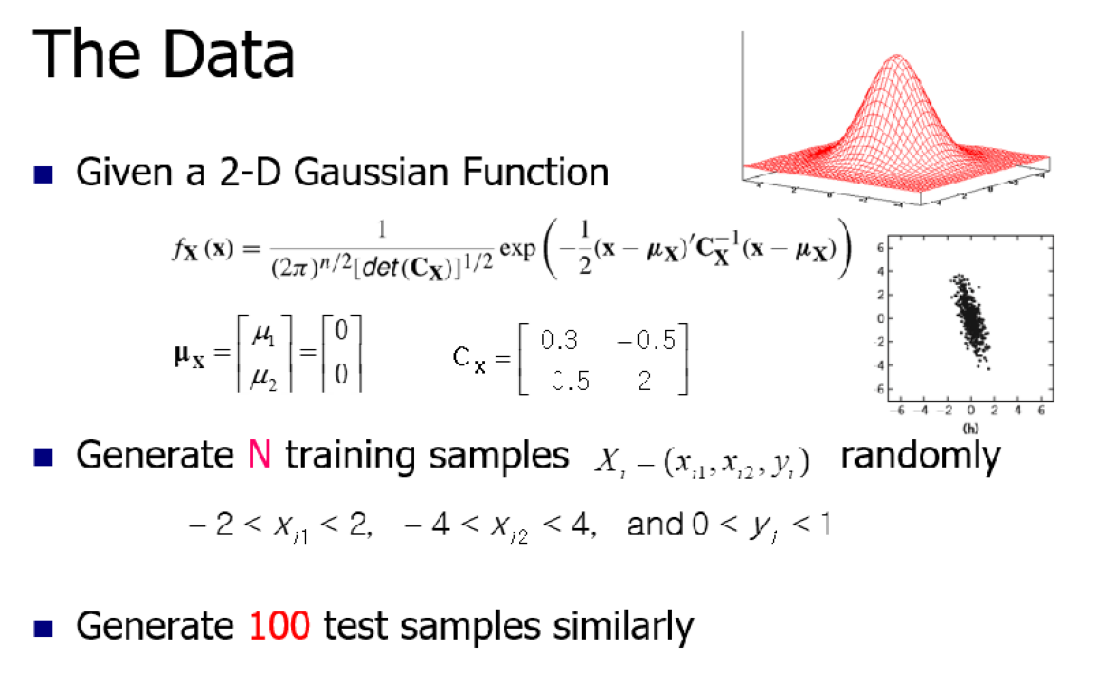

In [78]:
image = plt.imread("problem.png")
plt.figure(figsize=(14,14))
plt.axis("off"), plt.imshow(image);

In [79]:
rangex1 = (-2,2)
rangex2 = (-4,4)
mean = np.array([0.0,0.0])
cov = np.array([[0.3,-0.5],[-0.5,2]])
'''
Sử dụng hàm generate_data để tạo dữ liệu giả lập theo phân phối Gaussian và lưu vào các tệp CSV cho ba bộ dữ liệu: 
huấn luyện (train.csv), kiểm tra (test.csv), và xác thực (valid.csv).
'''
generate_data(n=20000, r1=rangex1, r2=rangex2, m=mean, c=cov, export_path="BT2/data/train.csv", verbose = 1);
generate_data(n=100, r1=rangex1, r2=rangex2, m=mean, c=cov, export_path="BT2/data/test.csv", verbose = 1);
generate_data(n=100, r1=rangex1, r2=rangex2, m=mean, c=cov, export_path="BT2/data/valid.csv", verbose = 1);

x1:  -1.9998964623221243 1.9993311149250297
x2:  -3.998157790301997 3.9995891131761256
x shape:  (20000, 2)
y:  5.402384454622519e-14 0.2688335252200819
y shape:  (20000,)
x1:  -1.9658356069630765 1.9979791177920299
x2:  -3.9028036952977967 3.944666797675122
x shape:  (100, 2)
y:  1.1375239965525056e-12 0.22596917954754467
y shape:  (100,)
x1:  -1.9701451519186475 1.9833964673670592
x2:  -3.9514465240744823 3.818263813202152
x shape:  (100, 2)
y:  8.45015674523685e-13 0.23977407527673475
y shape:  (100,)


In [80]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="BT2/data/train.csv", csv_valid="BT2/data/valid.csv", csv_test="BT2/data/test.csv")

Training samples:  20000  -- Shape:  (20000, 2) (20000,)
Validating samples:  100  -- Shape:  (100, 2) (100,)
Testing samples:  100  -- Shape:  (100, 2) (100,)


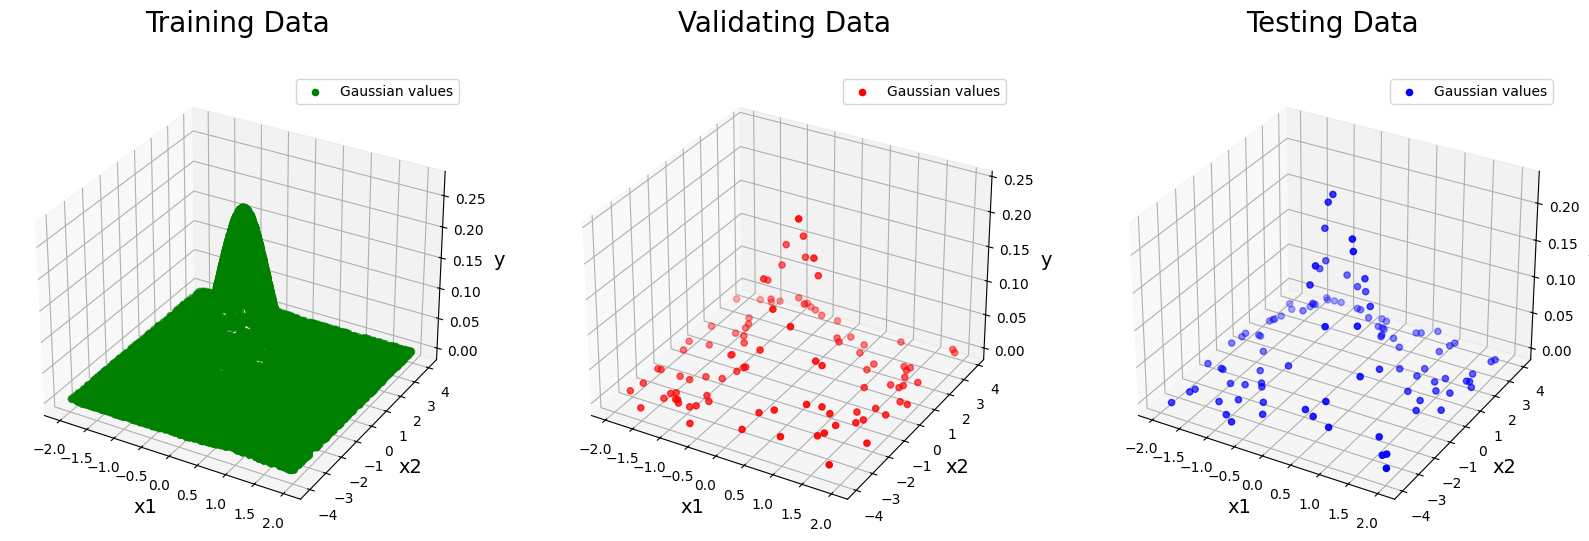

In [81]:
# In ra số lượng mẫu và hình dạng của các bộ dữ liệu huấn luyện, xác thực, và kiểm tra
'''
len(x_train): Số lượng mẫu trong bộ huấn luyện.
x_train.shape: Hình dạng của ma trận đặc trưng huấn luyện (số lượng mẫu và số lượng đặc trưng).
y_train.shape: Hình dạng của mảng nhãn huấn luyện.
'''
print("Training samples: ", len(x_train), " -- Shape: ", x_train.shape, y_train.shape)
print("Validating samples: ", len(x_valid), " -- Shape: ", x_valid.shape, y_valid.shape)
print("Testing samples: ", len(x_test), " -- Shape: ", x_test.shape, y_test.shape)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,3,1, projection='3d')
visualize_dataset(x_train, y_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,3,2, projection='3d')
visualize_dataset(x_valid, y_valid, color = "red", title = "Validating Data\n", ax = ax2)

ax3 = plt.subplot(1,3,3, projection='3d')
visualize_dataset(x_test, y_test, color = "blue", title = "Testing Data\n", ax = ax3)

## 1.4 Normalize data

In [82]:
'''
Mục đích của chuẩn hóa dữ liệu
- Chuẩn hóa giúp đảm bảo rằng tất cả các đặc trưng (features) của dữ liệu có phạm vi giá trị giống nhau, giúp thuật toán học máy hoạt động hiệu quả hơn.
- Ví dụ, trong các mô hình học máy, việc có các đặc trưng với phạm vi khác nhau có thể khiến mô hình tập trung quá mức vào một số đặc trưng nhất định, 
hoặc việc huấn luyện có thể bị chậm hoặc không ổn định.
'''
x_train, x_valid, x_test = normalize_data(x_train, x_valid, x_test)

*******************
Befor Normalization
*******************
Train min=-4.000, max=4.000
Valid min=-3.988, max=3.900
Test min=-3.915, max=3.885



Mean = [0.00902207 0.00523259], Std = [1.15040979 2.3102655 ]
*******************
After Normalization
*******************
Train min=-1.746, max=1.731
Valid min=-1.733, max=1.719
Test min=-1.743, max=1.679


# 2. NETWORK STRUCTURE

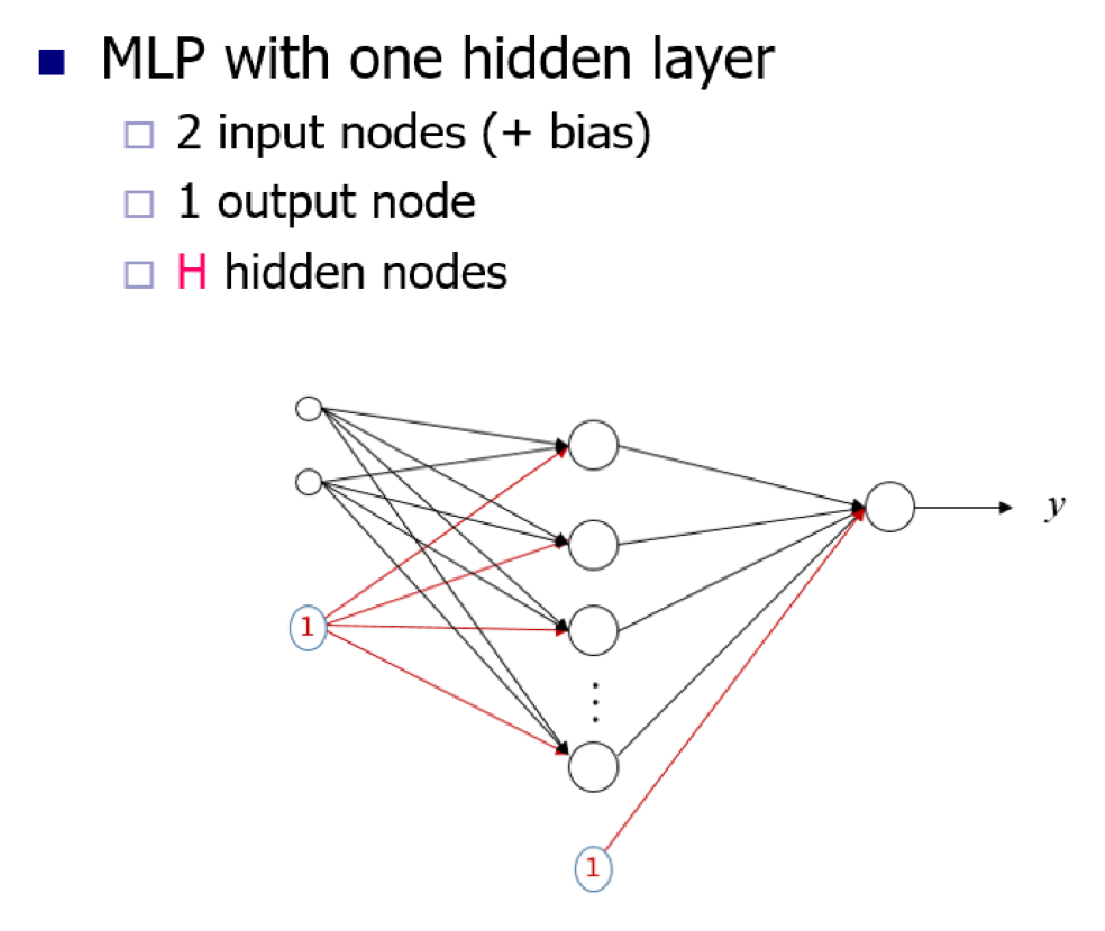

In [83]:
image = plt.imread("model.png")
plt.figure(figsize=(14,14))
plt.axis("off"), plt.imshow(image);

In [159]:
'''
- Xây dựng model phân loại nhị phân sử dụng mạng ANN với 1 lớp ẩn và 1 lớp đầu ra
'''
def build_model(H=10):
    inp = Input(shape=(2,), name='Input') #  tạo ra một lớp đầu vào cho mô hình với kích thước đầu vào là (2,), tức là mỗi mẫu dữ liệu sẽ có hai đặc trưng (features)
    '''
    Dense(units=1, activation='sigmoid'): Lớp đầu ra, có một neuron duy nhất (units=1) vì mô hình đang thực hiện phân loại nhị phân.
    Hàm kích hoạt của lớp đầu ra cũng là 'sigmoid', vì đây là mô hình phân loại nhị phân, và giá trị đầu ra sẽ là xác suất của lớp dương (có giá trị từ 0 đến 1).
    Lớp này nhận đầu vào từ lớp ẩn x và sinh ra đầu ra cuối cùng, được gọi là output_label.
    '''
    x = Dense(units=H, activation='sigmoid', name='fc')(inp)

    output_label = Dense(units=1, activation='sigmoid', name='output_layer')(x)
    
    # Dòng này xây dựng mô hình Keras với đầu vào inp và đầu ra output_label. Keras sẽ tự động kết nối các lớp theo đúng thứ tự.
    model = Model(inputs=inp, outputs=output_label)
    model.summary()
    return model
#model

In [85]:
# build a sample model with hidden node = 10
model = build_model(H=10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

# 3. EXPERIMENT 1:

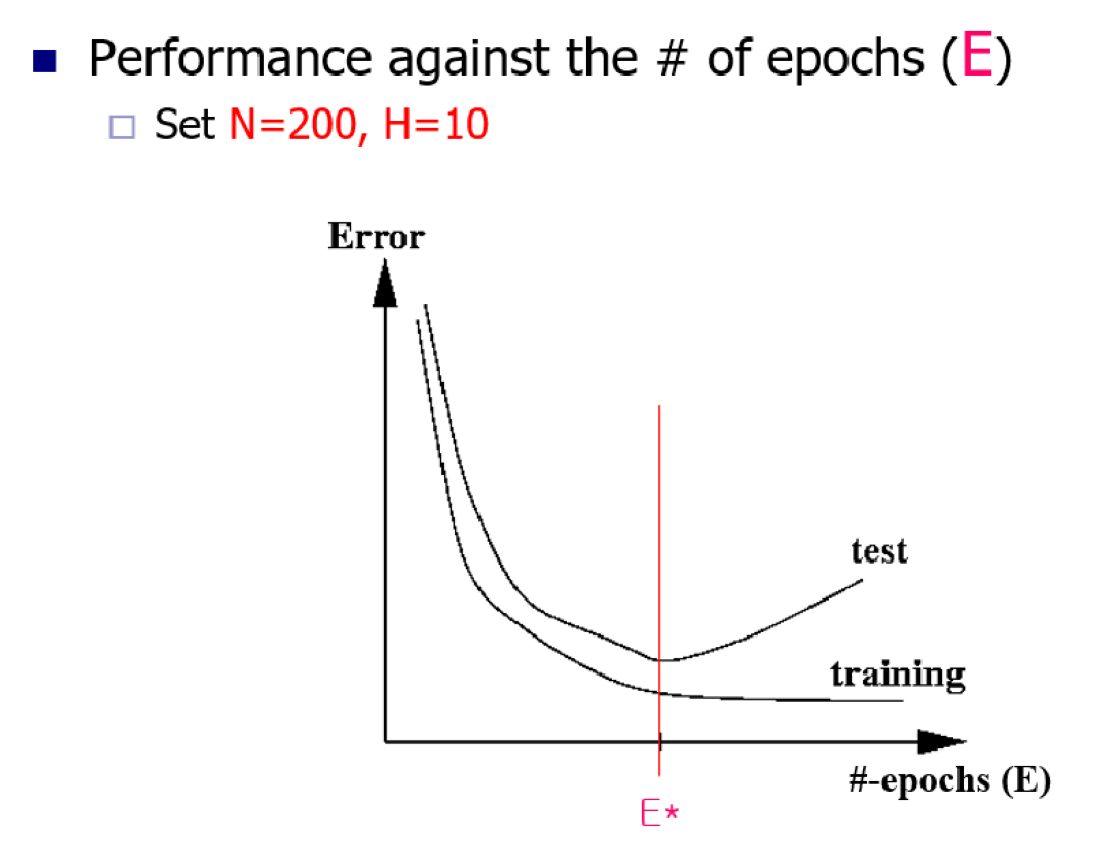

In [86]:
image = plt.imread("exp1.png")
plt.figure(figsize=(14,14))
plt.axis("off"), plt.imshow(image);

## 3.1. Train Data

Train: x-shape = (200, 2) y-shape = (200,)
Valid: x-shape = (100, 2) y-shape = (100,)


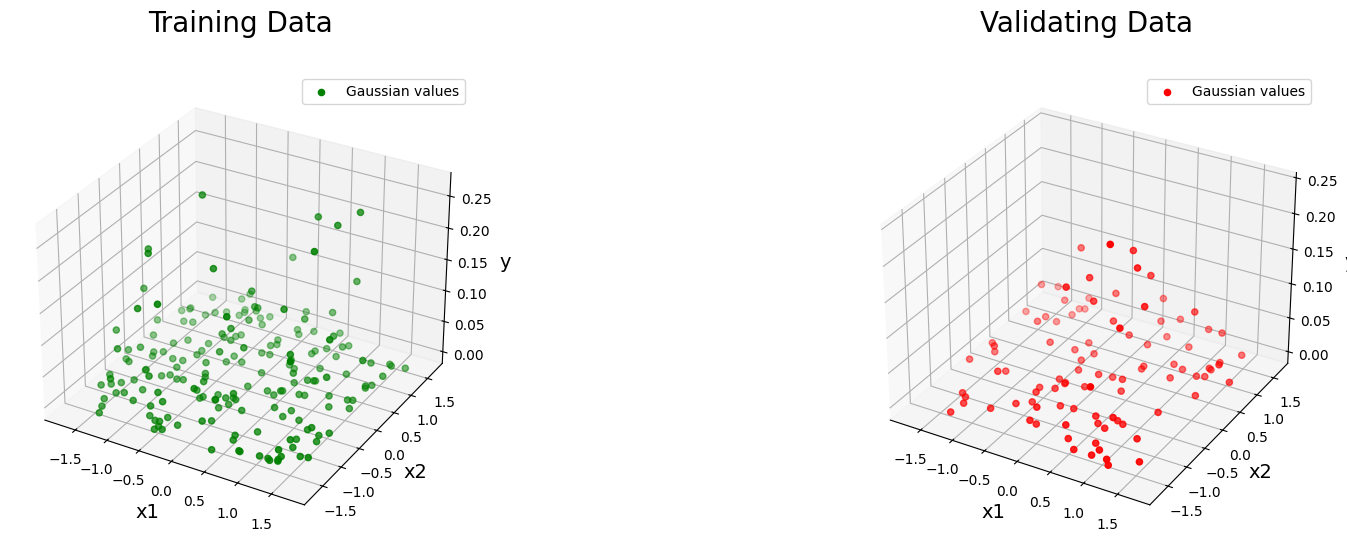

In [100]:
x_exp1_train, y_exp1_train = x_train[:200], y_train[:200]
x_exp1_valid, y_exp1_valid = x_valid, y_valid

print(f"Train: x-shape = {x_exp1_train.shape} y-shape = {y_exp1_train.shape}")
print(f"Valid: x-shape = {x_exp1_valid.shape} y-shape = {y_exp1_valid.shape}")

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,2,1, projection='3d')
visualize_dataset(x_exp1_train, y_exp1_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,2,2, projection='3d')
visualize_dataset(x_exp1_valid, y_exp1_valid, color = "red", title = "Validating Data\n", ax = ax2)

## 3.2. Model

In [101]:
# Tạo ra một mô hình học sâu (neural network) với số lượng đơn vị (units) trong lớp ẩn là 10
exp1_model = build_model(H=10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

## 3.3. Training

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

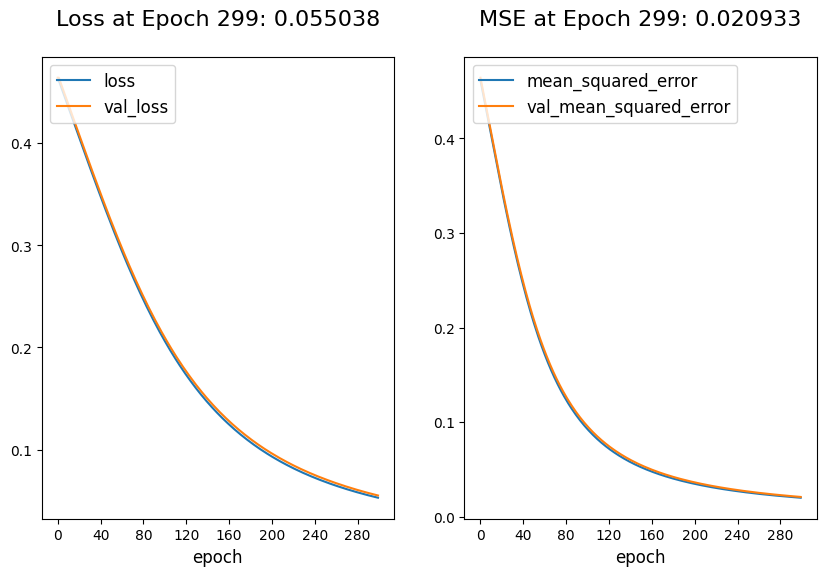

> training time is 3.4051 minutes


In [122]:
'''
 huấn luyện (training process) cho mô hình mạng nơ-ron sâu (deep neural network) với một số cấu hình như tối ưu hóa (optimization), 
 các callback để kiểm soát việc huấn luyện, và việc lưu trữ các mô hình tốt nhất trong quá trình huấn luyện.
'''

K.clear_session()
exp1_model = build_model(H=10)

# OPTIMIZATION
exp1_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

# CALLBACKS
callbacks = []

# + ModelCheckPoint
'''
lưu lại mô hình tốt nhất (dựa trên val_loss) trong suốt quá trình huấn luyện. Mô hình sẽ được lưu với tên theo mẫu template_name,
trong đó bao gồm số epoch và giá trị val_loss và val_mean_squared_error.
save_best_only=True: Chỉ lưu mô hình khi có cải thiện trong val_loss.
save_weights_only=False: Lưu cả mô hình đầy đủ (cấu trúc và trọng số).
'''
save_dir = "BT2/data/model/train_01"
template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
if os.path.exists(save_dir) == False: os.makedirs(save_dir)
modekcheckpoint_callback = ModelCheckpoint(filepath = os.path.join(save_dir, template_name),
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=False, # only weight, 
                                           mode='auto', # min, max, auto
                                           save_freq='epoch' # bao nhieu epoch moi xem xet 1 lan
                                          )
callbacks.append(modekcheckpoint_callback)

# + Early Stopping
'''
EarlyStopping giúp dừng huấn luyện sớm nếu val_loss không cải thiện trong patience=10 epoch liên tiếp.
'''
earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
callbacks.append(earlystopping_callback)


# + Visualize logs
review_logs = {}
'''
Callback này lưu lại logs huấn luyện tại mỗi epoch và vẽ đồ thị (visualize) các giá trị như 
loss, val_loss, mean_squared_error, val_mean_squared_error sau mỗi epoch.
'''
def custom_on_epoch_end(self, epoch, logs, **kwargs):  
    review_logs = kwargs["review_logs"]
    if epoch == 0:
        review_logs["epoch"] = [epoch]
        for key in logs.keys(): review_logs[key] = [logs[key]]
    # if
    review_logs["epoch"].append(epoch)
    for key in logs.keys(): review_logs[key].append(logs[key])
    
    visualize_data = review_logs
    group_view     = [{"x": "epoch", "y": ["loss", "val_loss"], 
                       "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n", 
                       "style": "median"}, 
                      {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                       "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n", 
                       "style": None}
                     ]
    fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False, save_path = os.path.join("BT2/data/model/train_01", "logs.png"))
    plt.close()
    if epoch == 0:
        display.display(fig, display_id="logs")
    else:
        display.update_display(fig, display_id="logs")
    pass
# custom_on_epoch_end

custom_callbacks = LambdaCallback()
custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
callbacks.append(custom_callbacks)

# TRAINING
batch_size = 128
epochs = 200

starting_time = time.time()
history = exp1_model.fit(x_exp1_train, y_exp1_train,
                    validation_data=(x_exp1_valid, y_exp1_valid),
                    batch_size=batch_size,
                    epochs=epochs, 
                    callbacks = callbacks, 
                    verbose = 0)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

## 3.4. Evaluating

In [123]:
'''
epoch_opt: Là chỉ số của epoch mà tại đó mô hình đạt hiệu suất tốt nhất trên tập validation dựa trên MSE.
Đây thường là epoch lý tưởng để đánh giá mô hình hoặc lưu mô hình.
'''
epoch_opt = np.argmin(history.history["val_mean_squared_error"])

In [124]:
save_name = template_name.format(epoch = epoch_opt + 1, 
                 val_mean_squared_error = history.history["val_mean_squared_error"][epoch_opt], 
                 val_loss= history.history["val_loss"][epoch_opt])
save_path = os.path.join(save_dir, save_name)
save_path

'BT2/data/model/train_01\\funcApxm_model_01_300_0.021_val_acc-0.021.keras'

Test loss: 0.020567093044519424
Test accuracy: 0.020567093044519424


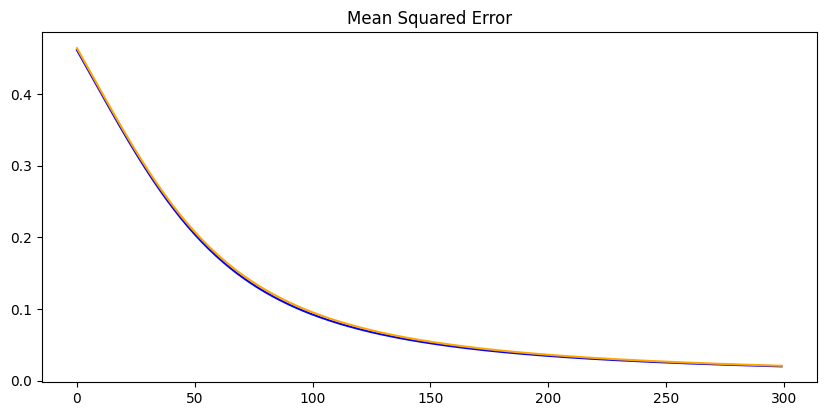

In [125]:
from keras.models import load_model
model = load_model(save_path)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
summarize_diagnostics(history)

## 3.5. Discussion

| Cấu hình | num epoch | Accuracy | Nhận xét |
|----------|-----------|----------|----------|
| 1 | 50 | 0.0976058840751648  |Độ chính xác cao nhất trong các cấu hình, cho thấy mô hình bắt đầu học và đạt kết quả khả quan.Có thể thử tăng số epoch để kiểm tra nếu mô hình tiếp tục cải thiện. |
| 2 |  100   | 0.054841428995132446 | Accuracy giảm đáng kể so với cấu hình 1. Mô hình có dấu hiệu underfitting, không học đủ từ dữ liệu.       |
| 3 |  150   | 0.039937738329172134 | Accuracy tiếp tục giảm, mô hình chưa học được thêm thông tin từ dữ liệu.       |
| 4 |  200   | 0.030268078669905663 | Accuracy giảm sâu hơn, xác nhận mô hình không bị overfit nhưng không tìm ra giải pháp tốt       |
| 5 |  250   | 0.02055135928094387  | Kết quả tiếp tục giảm, cho thấy mô hình bị underfitting nghiêm trọng.       |
| 6 |  300   | 0.020567093044519424 | Không cải thiện thêm so với cấu hình 5, có khả năng mô hình đạt giới hạn khả năng học hiện tại.       |

- Điều này cho thấy mô hình không cải thiện việc học mà ngược lại, bị underfitting nghiêm trọng.
- Mô hình không học đủ các đặc trưng từ dữ liệu hoặc không phù hợp với bài toán.
- Nếu overfitting xảy ra, ta sẽ thấy accuracy trên tập huấn luyện cao nhưng trên tập kiểm tra giảm sút. Tuy nhiên, ở đây cả hai đều giảm, điều này củng cố nhận định về underfitting.

# 4. EXPERIMENT 2:

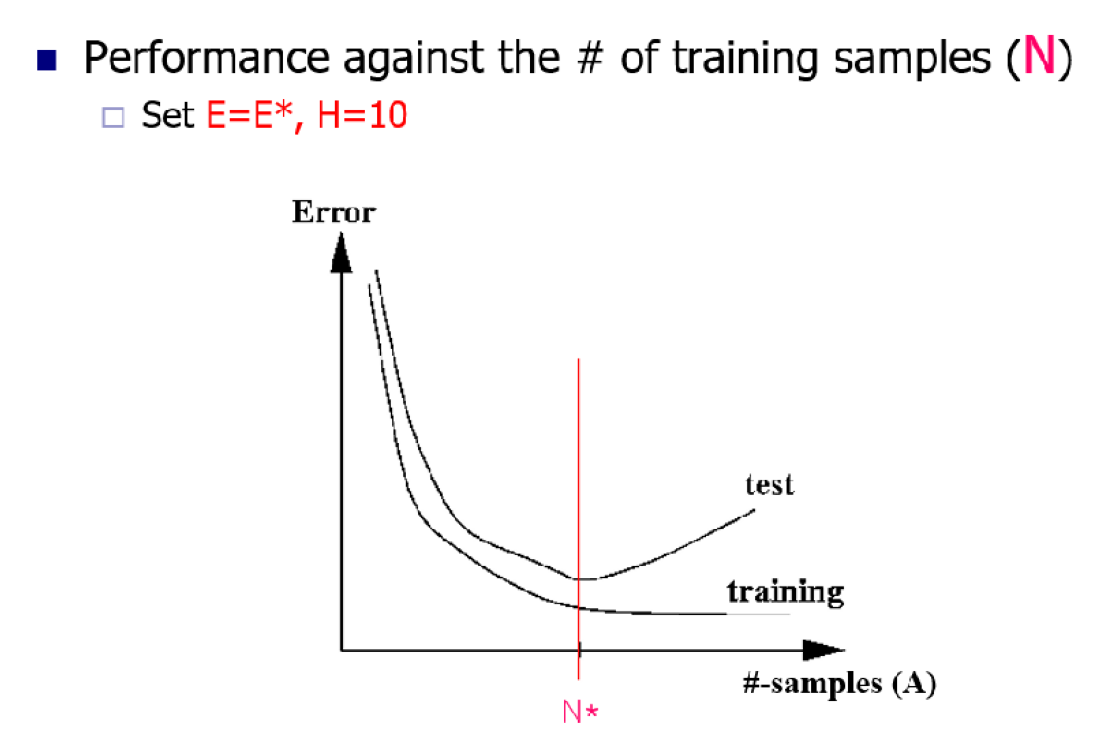

In [58]:
image = plt.imread("exp2.png")
plt.figure(figsize=(14,14))
plt.axis("off"), plt.imshow(image);

- Setup:
    - E* = 200
    - H = 10
    - N = 0 --> 2000, step = 200

## 4.1. Train Data

In [59]:
x_exp2_train, y_exp2_train = [], []
x_exp2_valid, y_exp2_valid = x_valid, y_valid
print("Train: ")
for size in range(200, 2001, 200):
    x_exp2_train.append(x_train[:size])
    y_exp2_train.append(y_train[:size])
    print(f"+ Size: {size} {x_exp2_train[-1].shape} {y_exp2_train[-1].shape}")
# for
print(f"Valid: {x_exp2_valid.shape} {y_exp2_valid.shape}")

Train: 
+ Size: 200 (200, 2) (200,)
+ Size: 400 (400, 2) (400,)
+ Size: 600 (600, 2) (600,)
+ Size: 800 (800, 2) (800,)
+ Size: 1000 (1000, 2) (1000,)
+ Size: 1200 (1200, 2) (1200,)
+ Size: 1400 (1400, 2) (1400,)
+ Size: 1600 (1600, 2) (1600,)
+ Size: 1800 (1800, 2) (1800,)
+ Size: 2000 (2000, 2) (2000,)
Valid: (100, 2) (100,)


## 4.2. Build model

In [60]:
exp2_model = build_model(H = 10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

## 4.3. Training

In [61]:
def train_model(train_id, x_local_train, y_local_train, 
                x_local_valid, y_local_valid, nb_epochs = 1000):
    
    K.clear_session()
    exp2_model = build_model(H=10)

    # OPTIMIZATION
    exp2_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

    # CALLBACKS
    callbacks = []

    # + ModelCheckPoint
    save_dir = f"BT2/data/model/train_02/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    modekcheckpoint_callback = ModelCheckpoint(filepath = os.path.join(save_dir, template_name),
                                               monitor='val_loss', 
                                               verbose=0, 
                                               save_best_only=True, 
                                               save_weights_only=False, # only weight, 
                                               mode='auto', # min, max, auto
                                               save_freq='epoch'  # bao nhieu epoch moi xem xet 1 lan
                                              )
    callbacks.append(modekcheckpoint_callback)

    # + Early Stopping
    # earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
    # callbacks.append(earlystopping_callback)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):   
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"], 
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n", 
                           "style": "median"}, 
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n", 
                           "style": None}
                         ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False, 
                             save_path = os.path.join(f"BT2/data/model/train_02/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass
    # custom_on_epoch_end

    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks)

    # TRAINING
    batch_size = 128
    epochs = nb_epochs

    starting_time = time.time()
    history = exp2_model.fit(x_local_train, y_local_train,
                        validation_data=(x_local_valid, y_local_valid),
                        batch_size=batch_size,
                        epochs=epochs, 
                        callbacks = callbacks, 
                        verbose = 0)
    print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))
    return history
# train_model

Train id: 0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

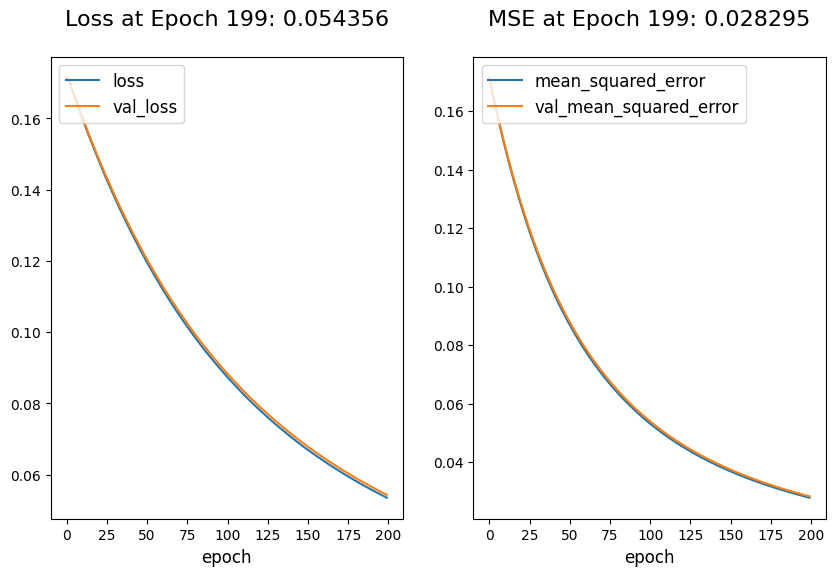

> training time is 1.5172 minutes
Train id: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

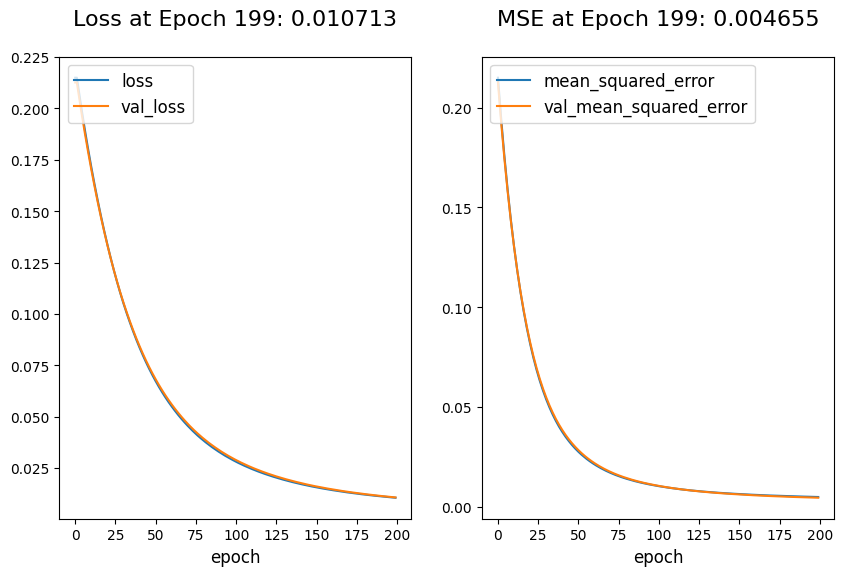

> training time is 1.6326 minutes
Train id: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

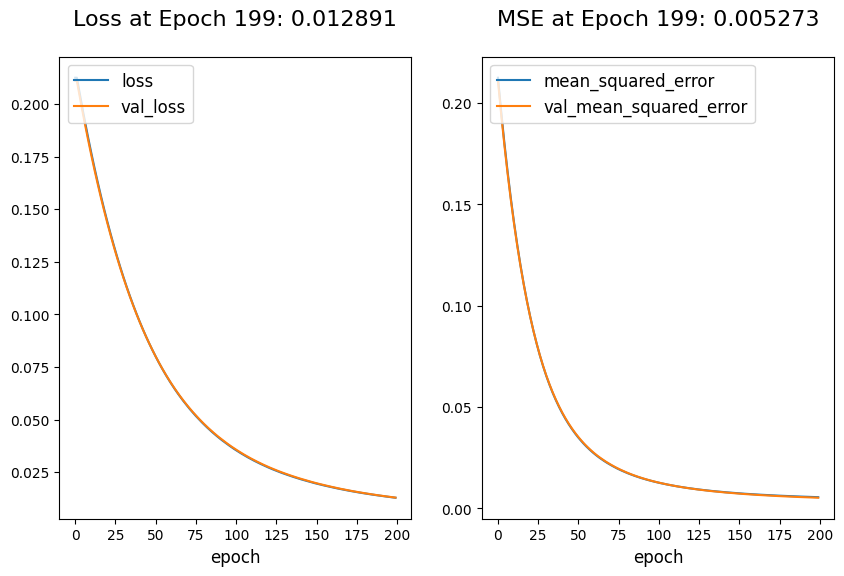

> training time is 1.5998 minutes
Train id: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

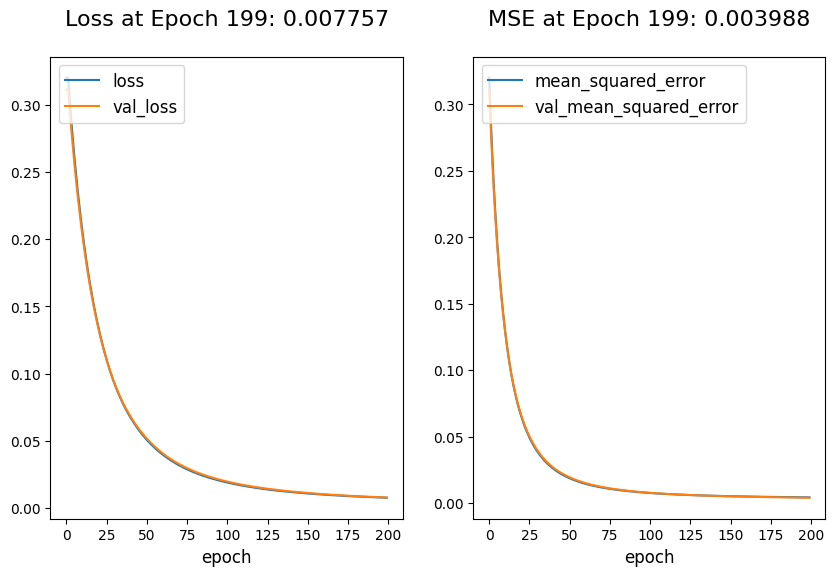

> training time is 1.7040 minutes
Train id: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

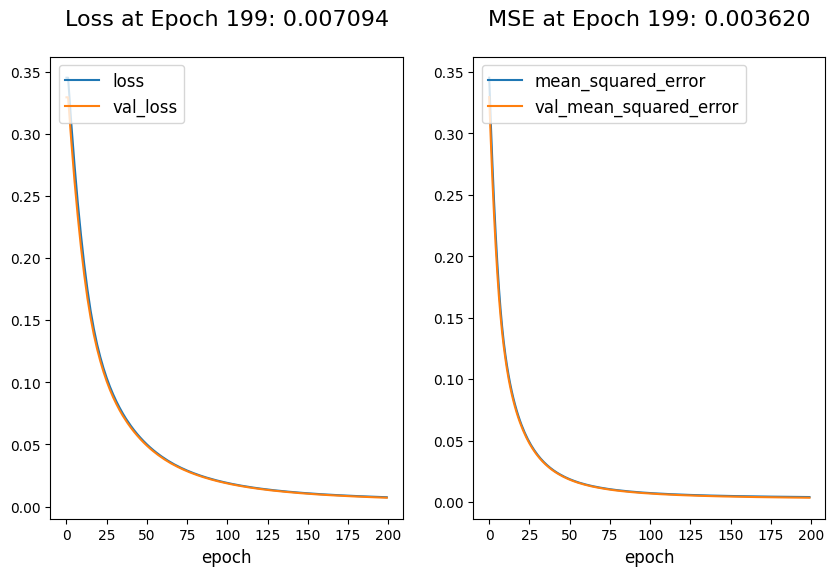

> training time is 2.1282 minutes
Train id: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

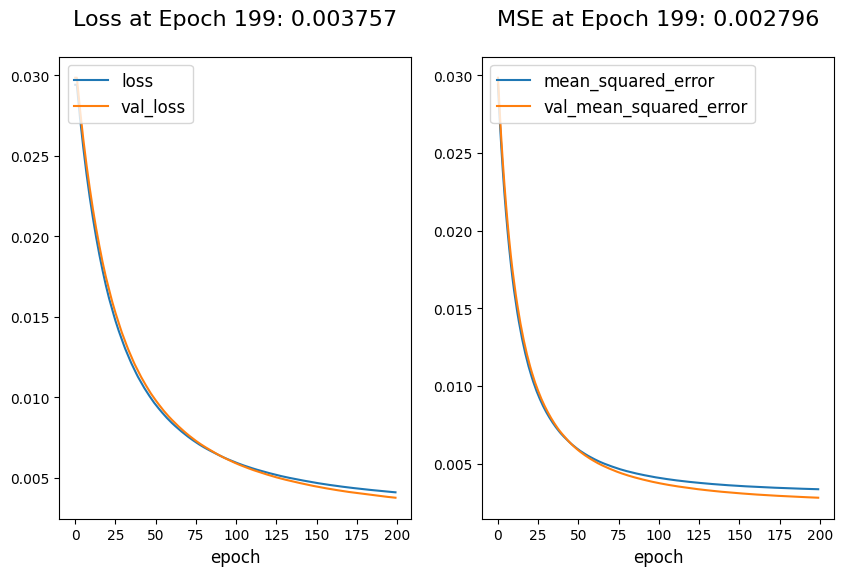

> training time is 1.8181 minutes
Train id: 6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

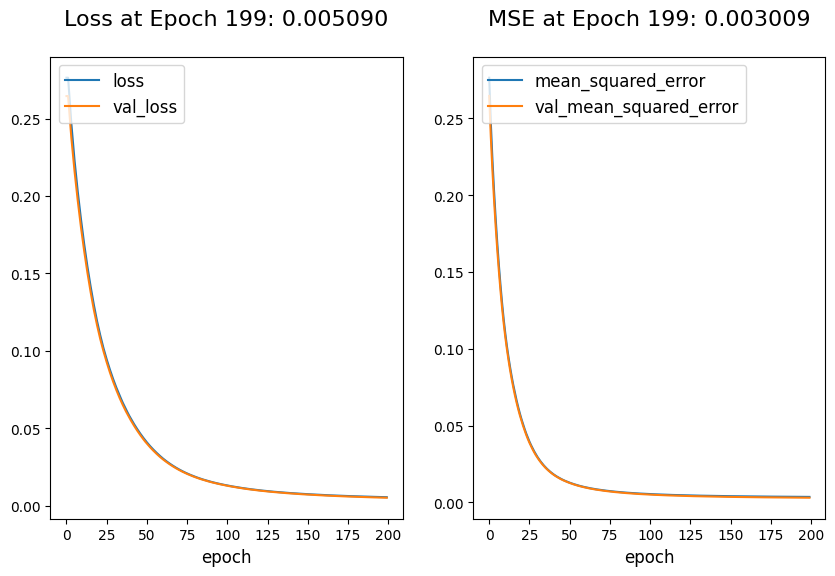

> training time is 2.0054 minutes
Train id: 7


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

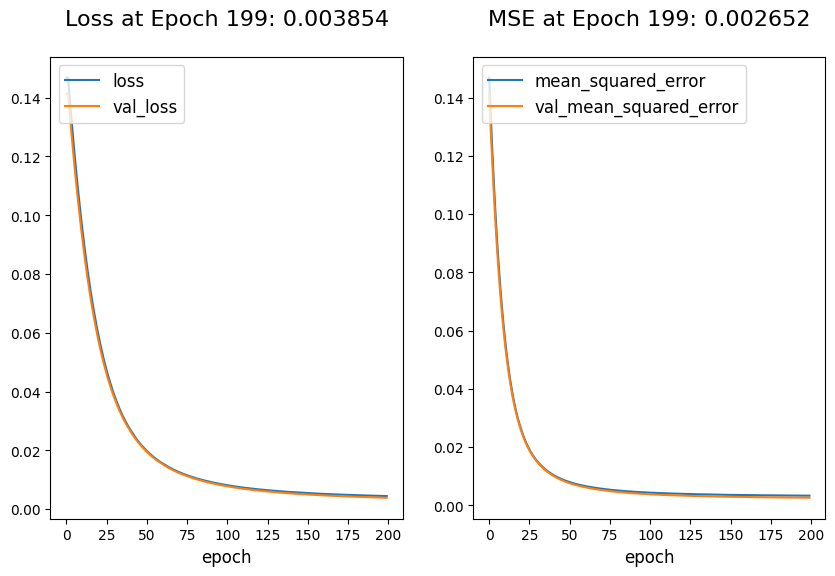

> training time is 1.8770 minutes
Train id: 8


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

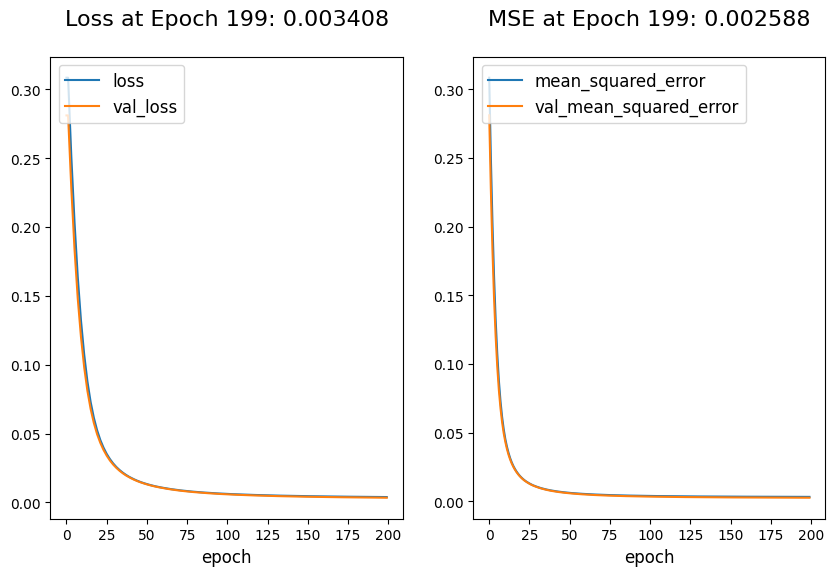

> training time is 1.9917 minutes
Train id: 9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

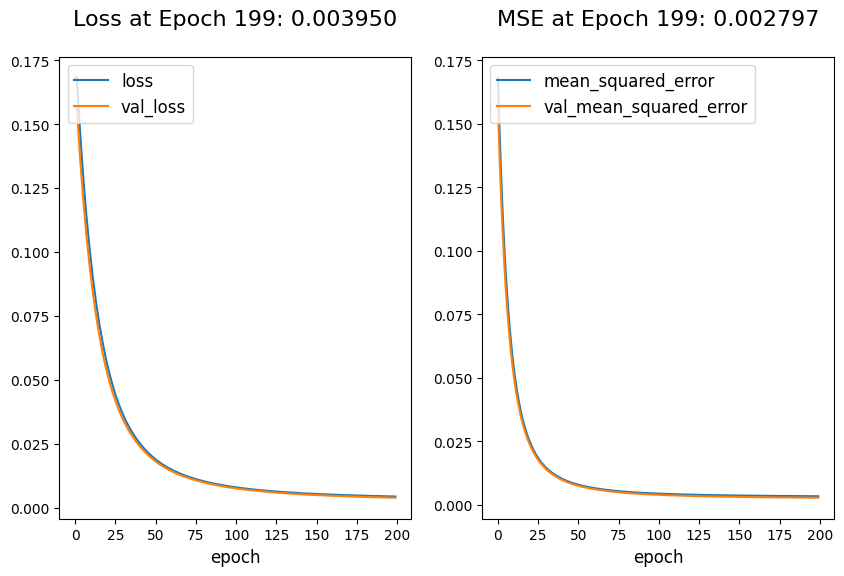

> training time is 1.9665 minutes


In [62]:
history = []
for i in range(len(x_exp2_train)):
    print(f"Train id: {i}")
    temp_history = train_model(i, x_exp2_train[i], y_exp2_train[i], x_exp2_valid, y_exp2_valid, nb_epochs = 200)
    history.append(temp_history)
# for

## 4.4. Evaluating

In [63]:
errors = []
for i in range(len(history)):
    epoch_opt = np.argmin(history[i].history["val_mean_squared_error"])
    error = history[i].history["val_mean_squared_error"][epoch_opt]
    errors.append(error)
# for
sizes = list(range(200, 2001, 200))

In [64]:
vt_min = np.argmin(np.array(errors))
print(f"Min Error at size={sizes[vt_min]} with error = {errors[vt_min]}")

Min Error at size=2000 with error = 0.004565468057990074


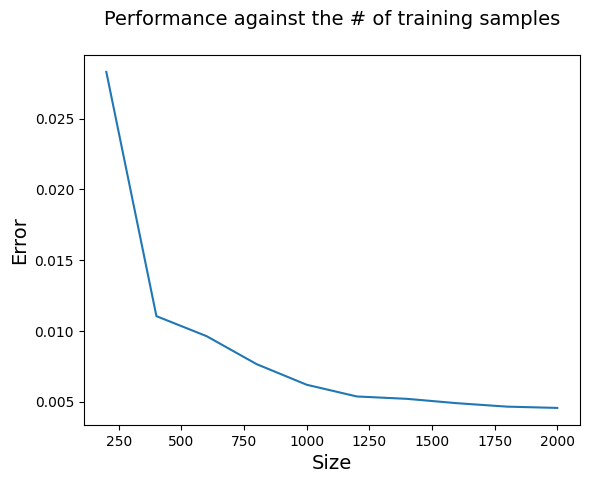

In [65]:
plt.plot(sizes, errors)
plt.xlabel("Size", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.title("Performance against the # of training samples\n", fontsize = 14);

## 4.5. Discussion
- Khi kích thước tập huấn luyện tăng lên, lỗi của mô hình giảm xuống. 
- Tốc độ giảm Error chậm lại khi kích thước tập huấn luyện tăng lên. Đây là quy luật về mức độ giảm dần - đến một lúc nào đó, việc thêm dữ liệu huấn luyện không cải thiện đáng kể hiệu suất của mô hình.
- Đường cong Error giảm mạnh ban đầu, từ khoảng 0.022 với tập nhỏ (250 mẫu) xuống khoảng 0.01 với tập trung bình (1000 mẫu). Điều này cho thấy mô hình rất được cải thiện khi tăng kích thước tập huấn luyện ở giai đoạn đầu.
- Khi kích thước tập tiếp tục tăng, đường cong lỗi trở nên ngang, từ 0.01 với 1000 mẫu xuống khoảng 0.005 với 2000 mẫu. Điều này cho thấy mô hình đang tiếp cận hiệu suất tối đa, và việc tăng kích thước tập huấn luyện hơn nữa có thể không dẫn đến cải thiện đáng kể.

# 5. EXPERIMENT 3:

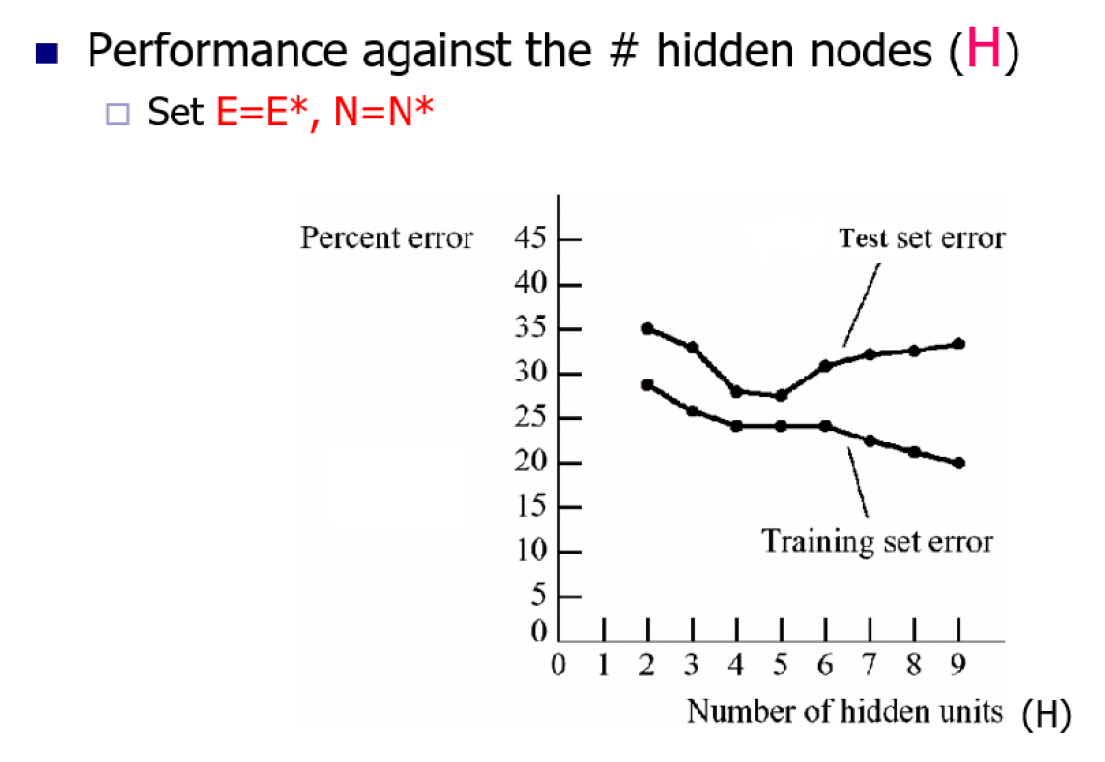

In [67]:
image = plt.imread("exp3.png")
plt.figure(figsize=(14,14))
plt.axis("off"), plt.imshow(image);

- Setup:
    - E* = 200
    - H = 1 - 10
    - N = 1800

## 5.1. Train Data

Train: x-shape = (1800, 2) y-shape = (1800,)
Valid: x-shape = (100, 2) y-shape = (100,)


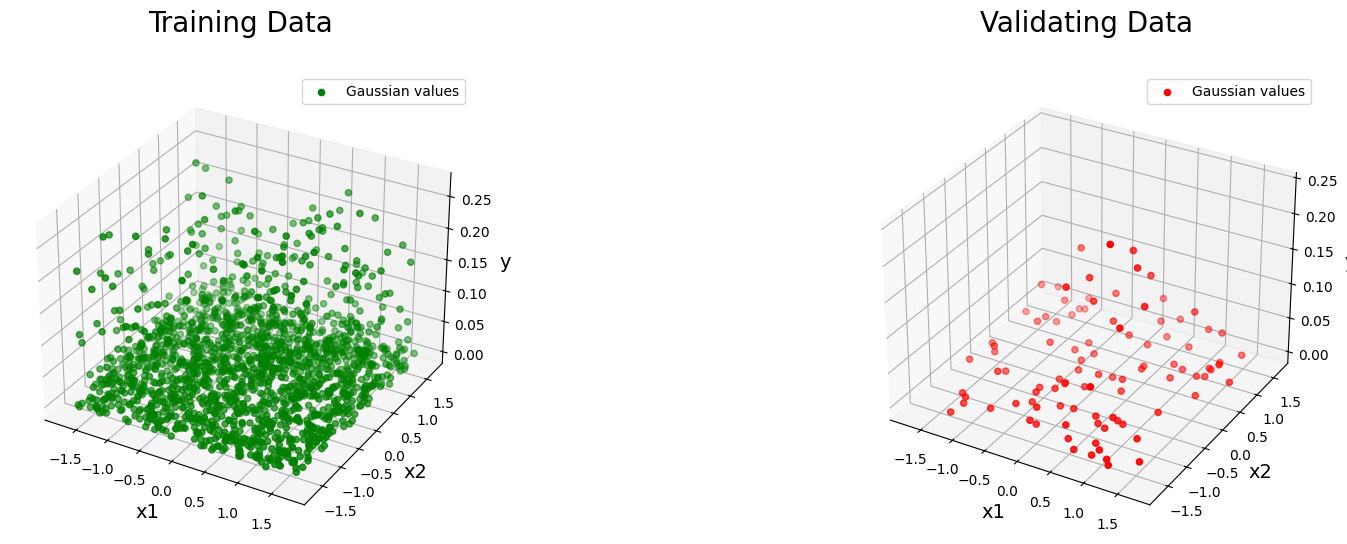

In [171]:
x_exp3_train, y_exp3_train = x_train[:1800], y_train[:1800]
x_exp3_valid, y_exp3_valid = x_valid, y_valid

print(f"Train: x-shape = {x_exp3_train.shape} y-shape = {y_exp3_train.shape}")
print(f"Valid: x-shape = {x_exp3_valid.shape} y-shape = {y_exp3_valid.shape}")

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,2,1, projection='3d')
visualize_dataset(x_exp3_train, y_exp3_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,2,2, projection='3d')
visualize_dataset(x_exp3_valid, y_exp3_valid, color = "red", title = "Validating Data\n", ax = ax2)

## 5.2. Model

In [172]:
exp3_model = build_model(H=10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

## 5.3. Training

In [173]:
def train_model(train_id, x_local_train, y_local_train, x_local_valid, y_local_valid, n_hidden = 10, nb_epochs = 1000):
    
    K.clear_session()
    exp3_model = build_model(H=n_hidden)

    # OPTIMIZATION
    exp3_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

    # CALLBACKS
    callbacks = []

    # + ModelCheckPoint
    save_dir = f"./data/model/train_03/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    modekcheckpoint_callback = ModelCheckpoint(filepath = os.path.join(save_dir, template_name),
                                               monitor='val_loss', 
                                               verbose=0, 
                                               save_best_only=True, 
                                               save_weights_only=False, # only weight, 
                                               mode='auto', # min, max, auto
                                               save_freq='epoch'   # bao nhieu epoch moi xem xet 1 lan
                                              )
    callbacks.append(modekcheckpoint_callback)

    # + Early Stopping
    # earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
    # callbacks.append(earlystopping_callback)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):   
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"], 
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n", 
                           "style": "median"}, 
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n", 
                           "style": None}
                         ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False, 
                             save_path = os.path.join(f"BT2/data/model/train_03/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass
    # custom_on_epoch_end

    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks)

    # TRAINING
    batch_size = 128
    epochs = nb_epochs

    starting_time = time.time()
    history = exp3_model.fit(x_local_train, y_local_train,
                        validation_data=(x_local_valid, y_local_valid),
                        batch_size=batch_size,
                        epochs=epochs, 
                        callbacks = callbacks, 
                        verbose = 0)
    print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))
    return history
# train_model

Train id: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

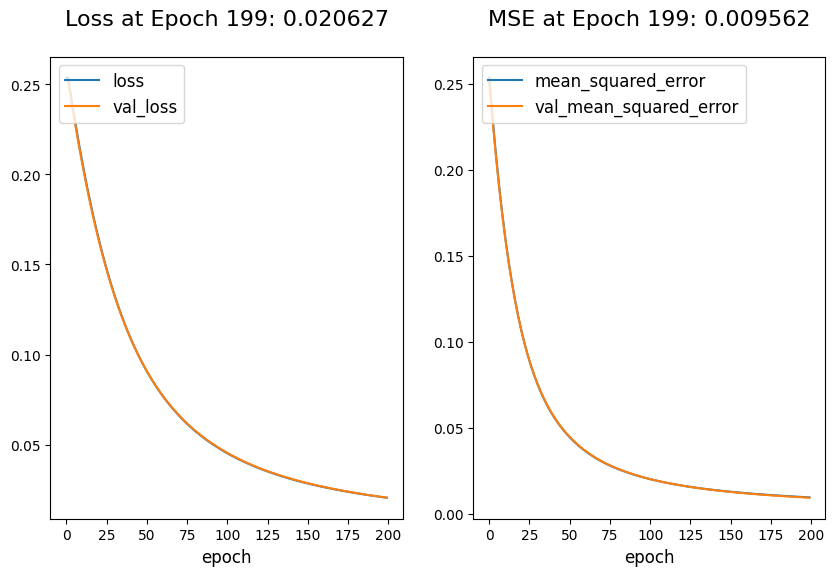

> training time is 2.5334 minutes
Train id: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

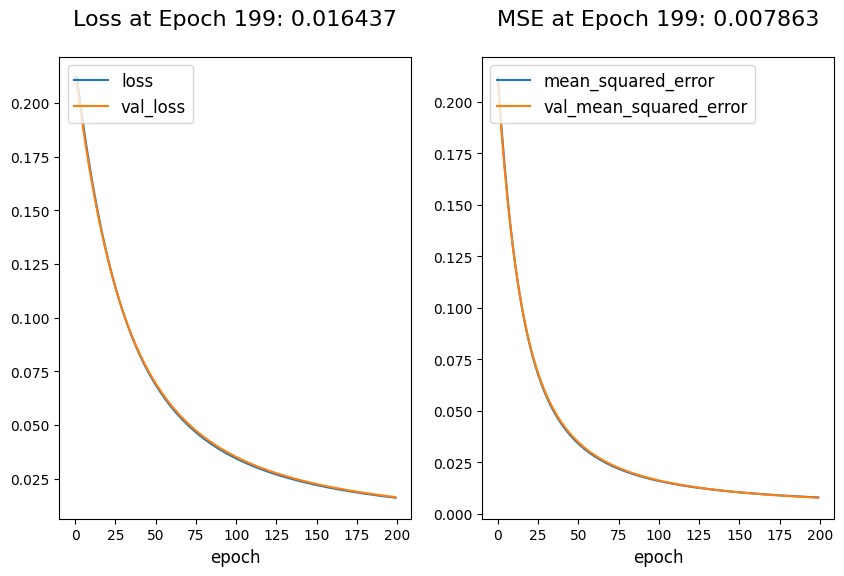

> training time is 2.5077 minutes
Train id: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

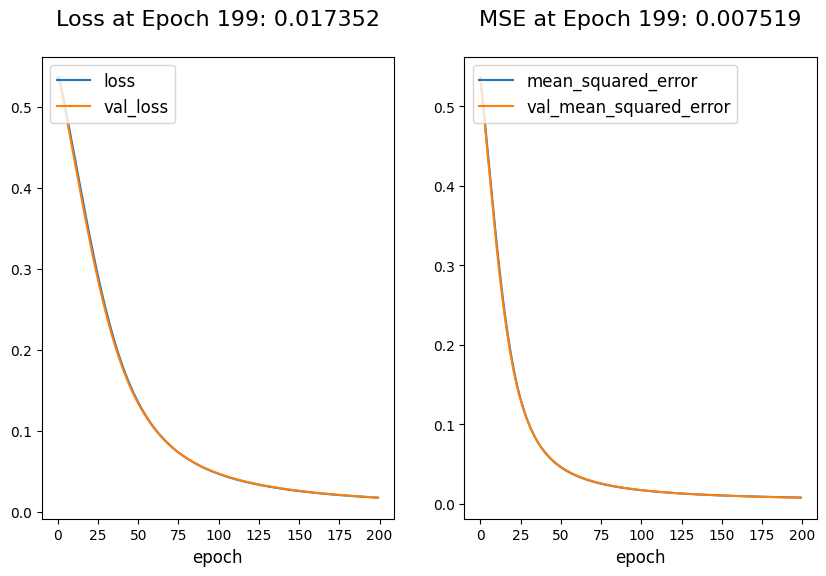

> training time is 2.2067 minutes
Train id: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

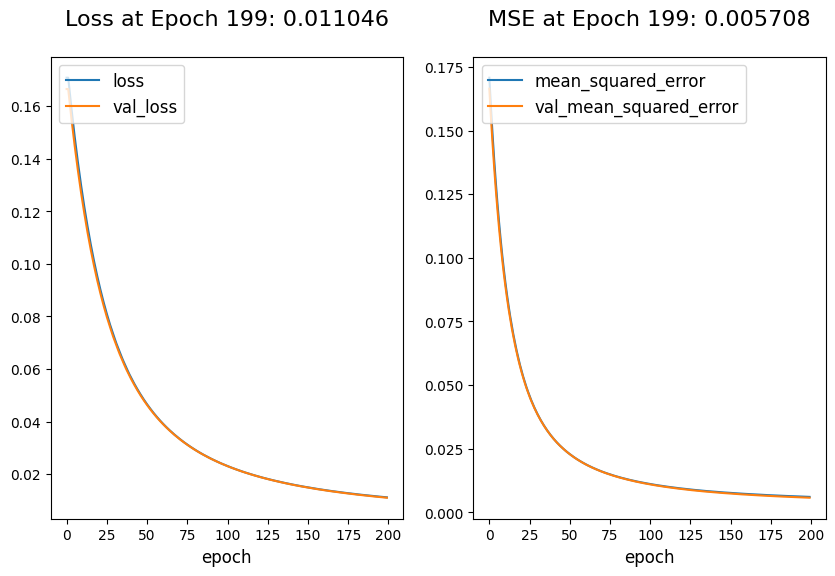

> training time is 3.1109 minutes
Train id: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 5)                   │              15 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

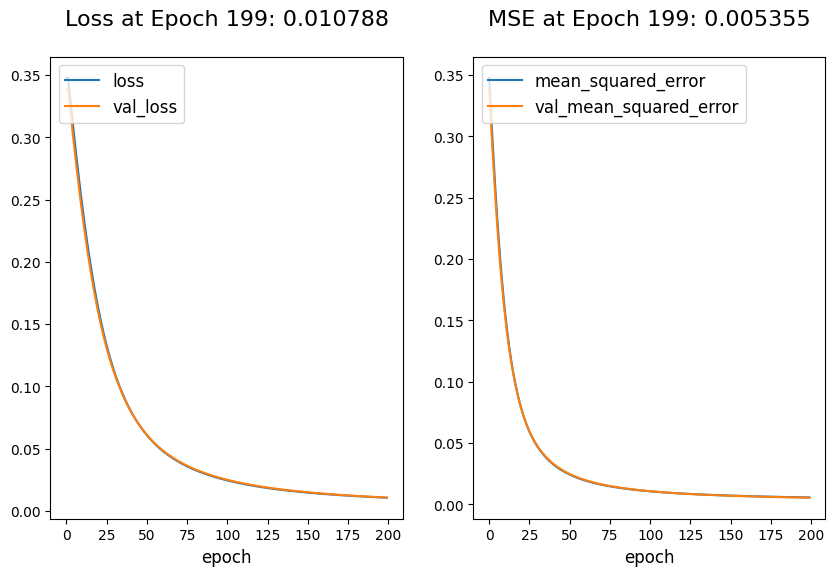

> training time is 2.0902 minutes
Train id: 6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 6)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

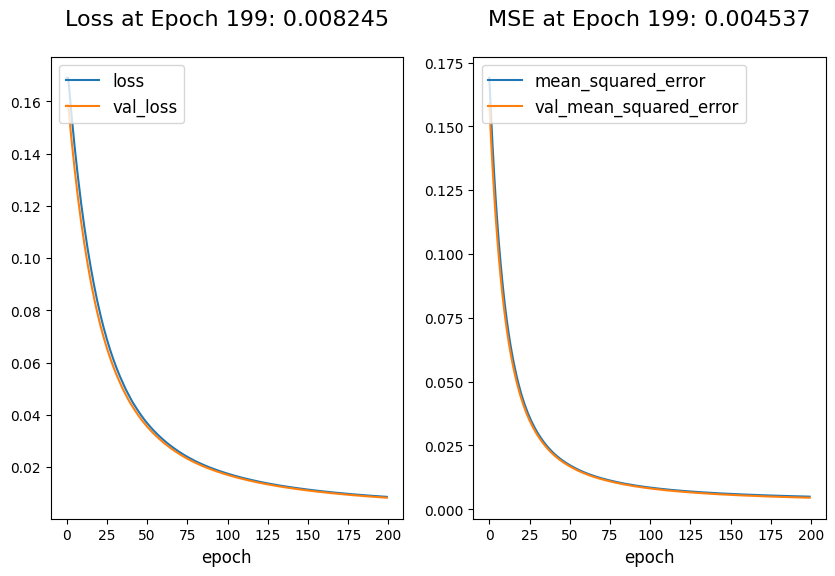

> training time is 2.1206 minutes
Train id: 7


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 7)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

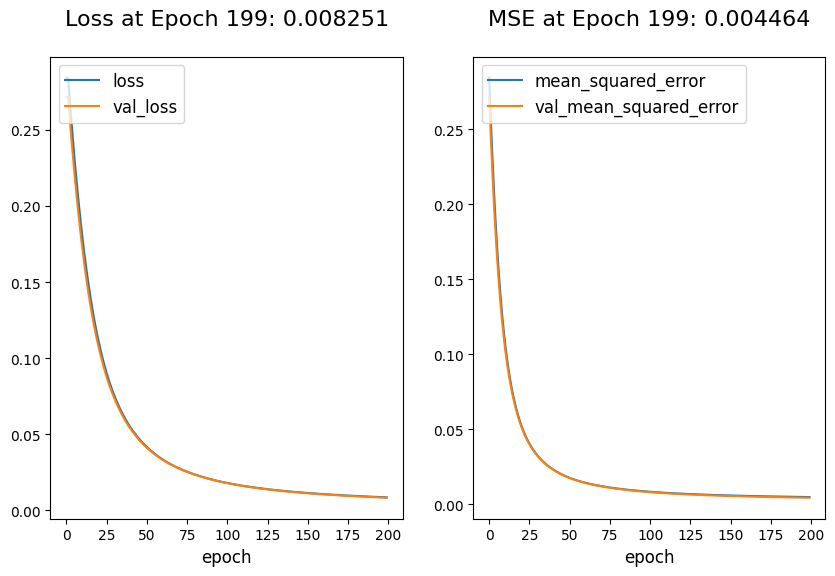

> training time is 1.8036 minutes
Train id: 8


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

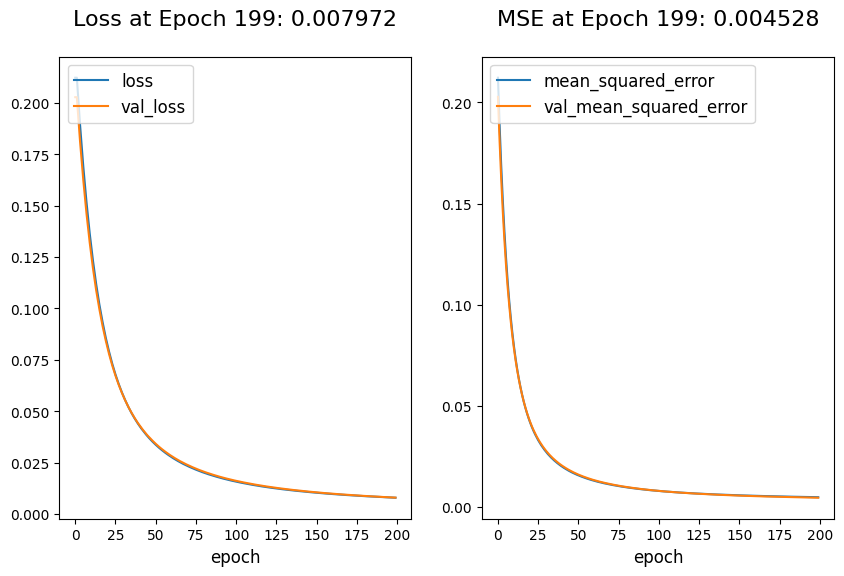

> training time is 2.1552 minutes
Train id: 9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 9)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

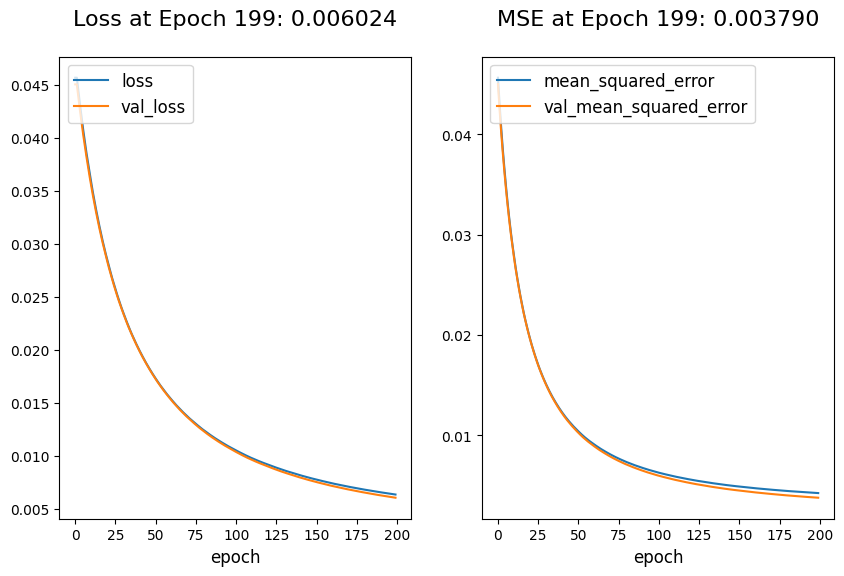

> training time is 1.8136 minutes
Train id: 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

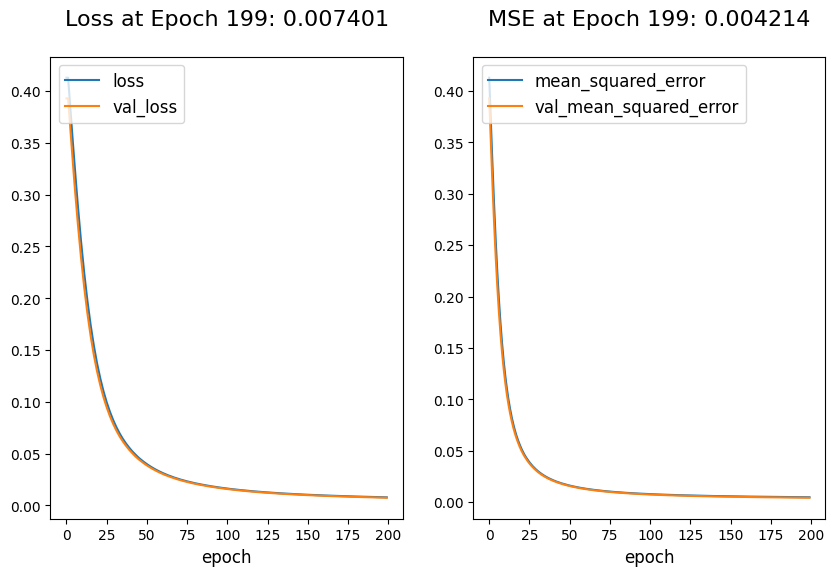

> training time is 1.7072 minutes


In [174]:
history = []
for i in range(1, 11, 1):
    print(f"Train id: {i}")
    temp_history = train_model(i, x_exp3_train, y_exp3_train, x_exp3_valid, y_exp3_valid, n_hidden=i, nb_epochs = 200)
    history.append(temp_history)
# for

## 5.4. Evaluating

In [175]:
errors = []
for i in range(len(history)):
    epoch_opt = np.argmin(history[i].history["val_mean_squared_error"])
    error = history[i].history["val_mean_squared_error"][epoch_opt]
    errors.append(error)
# for
hiddens = list(range(1, 11, 1))

In [176]:
vt_min = np.argmin(np.array(errors))
print(f"Min Error at n_hidden={hiddens[vt_min]} with error = {errors[vt_min]}")

Min Error at n_hidden=9 with error = 0.0037901150062680244


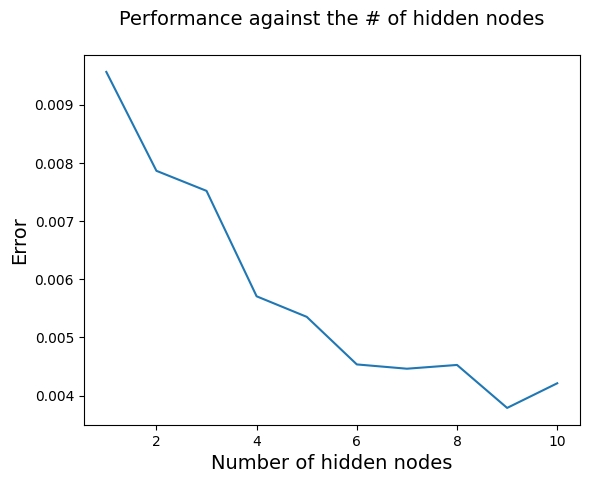

In [177]:
plt.plot(hiddens, errors)
plt.xlabel("Number of hidden nodes", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.title("Performance against the # of hidden nodes\n", fontsize = 14);

## 5.5. Discussion
- Khi số lượng nút ẩn trong mô hình tăng lên, Error trung bình bình phương (MSE) giảm dần. Tuy nhiên, hiệu suất bắt đầu đạt đỉnh khi số nút ẩn khoảng 6-8. Điều này cho thấy tăng thêm độ phức tạp của mô hình sau đó không cải thiện đáng kể. Vì vậy, một mô hình với khoảng 6-8 nút ẩn có thể là lựa chọn hợp lý, vì nó cân bằng giữa độ phức tạp và hiệu suất.
- Tối ưu hóa với số lượng nút ẩn là 9 với lỗi là 0.0037901150062680244

## 6. EXPERIMENT 4:

### 6.1. Train Data

Train: x-shape = (1800, 2) y-shape = (1800,)
Valid: x-shape = (100, 2) y-shape = (100,)


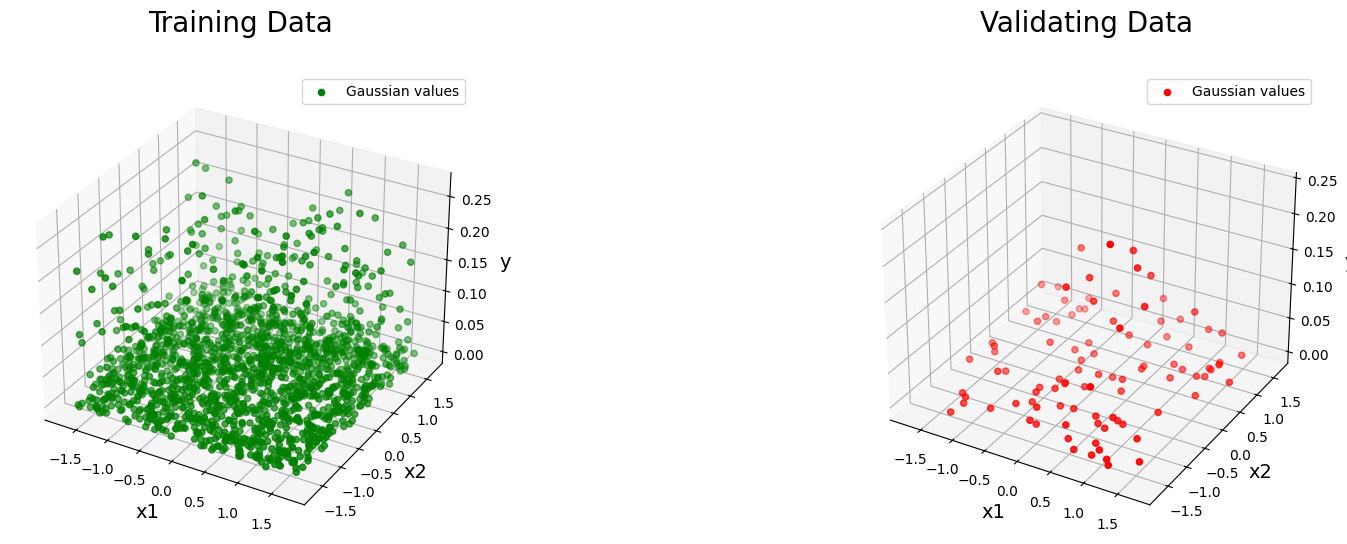

In [137]:
x_exp3_train, y_exp3_train = x_train[:1800], y_train[:1800]
x_exp3_valid, y_exp3_valid = x_valid, y_valid

print(f"Train: x-shape = {x_exp3_train.shape} y-shape = {y_exp3_train.shape}")
print(f"Valid: x-shape = {x_exp3_valid.shape} y-shape = {y_exp3_valid.shape}")

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,2,1, projection='3d')
visualize_dataset(x_exp3_train, y_exp3_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,2,2, projection='3d')
visualize_dataset(x_exp3_valid, y_exp3_valid, color = "red", title = "Validating Data\n", ax = ax2)

### 6.2. Model

In [160]:
exp3_model = build_model(H=10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

### 6.3. Training

In [161]:
def train_model(train_id, x_local_train, y_local_train, x_local_valid, y_local_valid, n_hidden = 10, nb_epochs = 1000):
    
    K.clear_session()
    exp3_model = build_model(H=n_hidden)

    # OPTIMIZATION
    exp3_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

    # CALLBACKS
    callbacks = []

    # + ModelCheckPoint
    save_dir = f"./data/model/train_03/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    modekcheckpoint_callback = ModelCheckpoint(filepath = os.path.join(save_dir, template_name),
                                               monitor='val_loss', 
                                               verbose=0, 
                                               save_best_only=True, 
                                               save_weights_only=False, # only weight, 
                                               mode='auto', # min, max, auto
                                               save_freq='epoch'   # bao nhieu epoch moi xem xet 1 lan
                                              )
    callbacks.append(modekcheckpoint_callback)

    # + Early Stopping
    # earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
    # callbacks.append(earlystopping_callback)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):   
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"], 
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n", 
                           "style": "median"}, 
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n", 
                           "style": None}
                         ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False, 
                             save_path = os.path.join(f"BT2/data/model/train_03/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass
    # custom_on_epoch_end

    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks)

    # TRAINING
    batch_size = 128
    epochs = nb_epochs

    starting_time = time.time()
    history = exp3_model.fit(x_local_train, y_local_train,
                        validation_data=(x_local_valid, y_local_valid),
                        batch_size=batch_size,
                        epochs=epochs, 
                        callbacks = callbacks, 
                        verbose = 0)
    print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))
    return history
# train_model

Train id: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

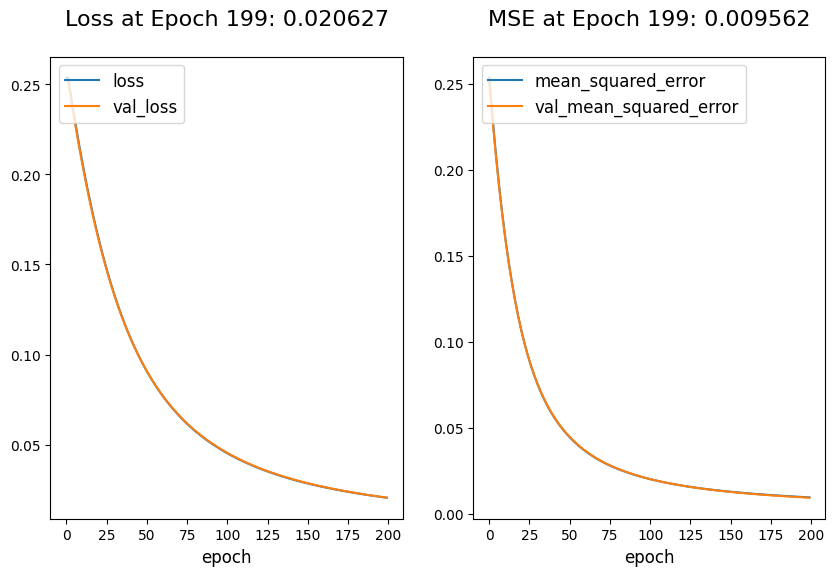

> training time is 5.5356 minutes
Train id: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

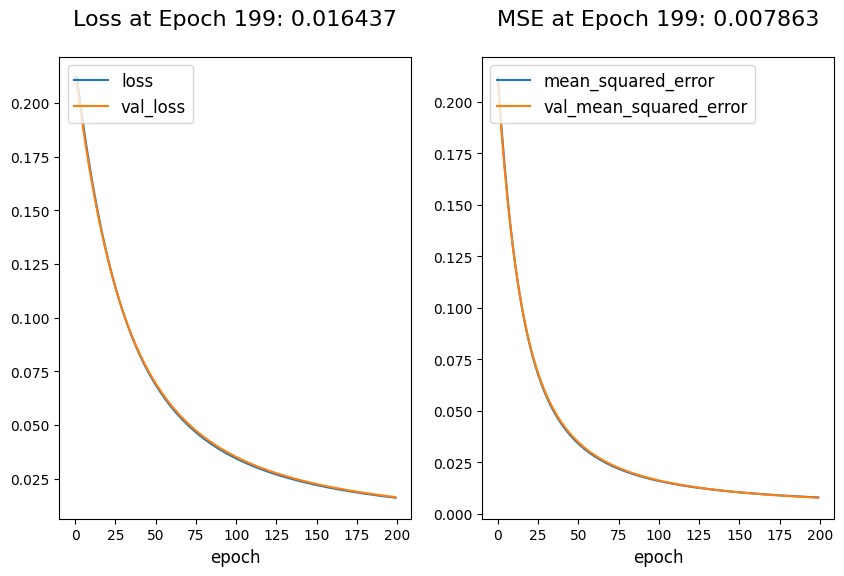

> training time is 3.1176 minutes
Train id: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

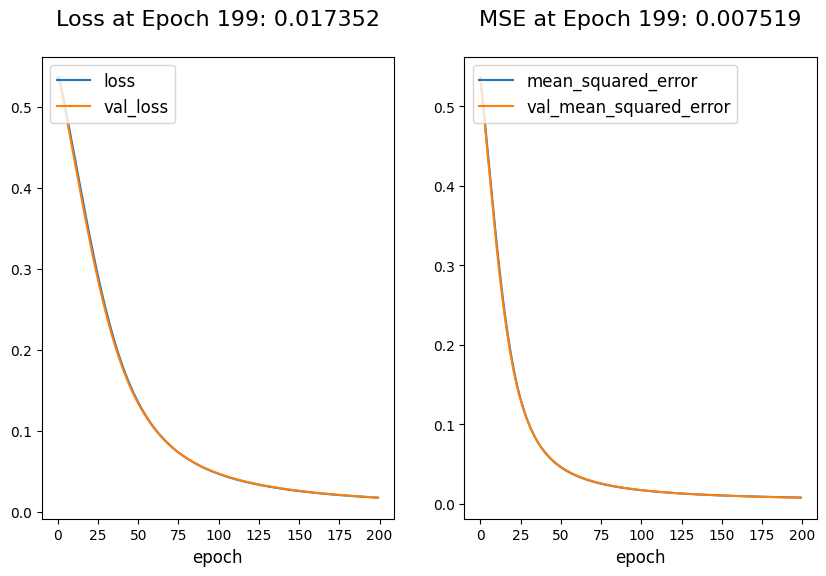

> training time is 2.9139 minutes
Train id: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

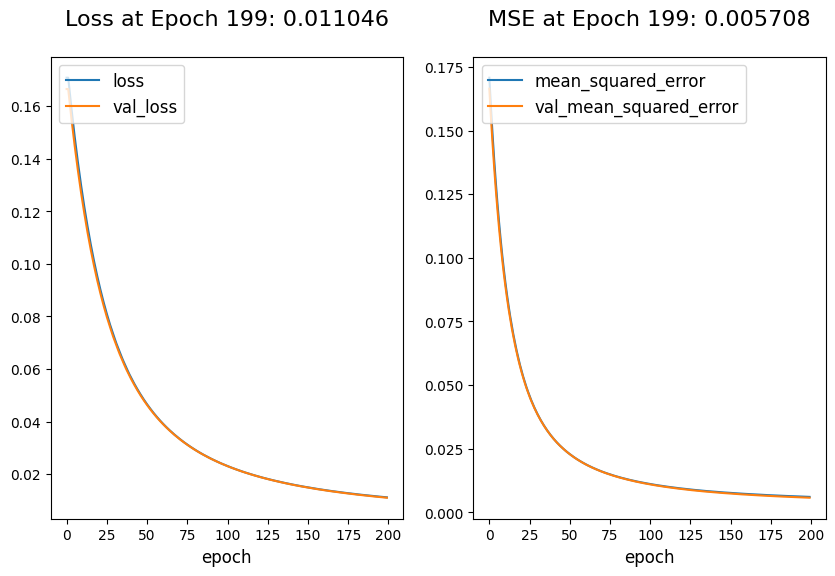

> training time is 2.7859 minutes
Train id: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 5)                   │              15 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

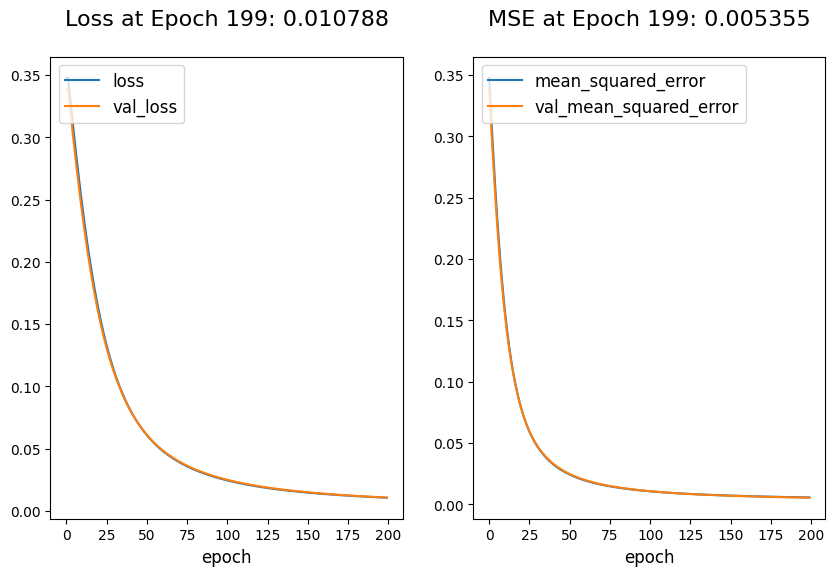

> training time is 1.7090 minutes
Train id: 6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 6)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

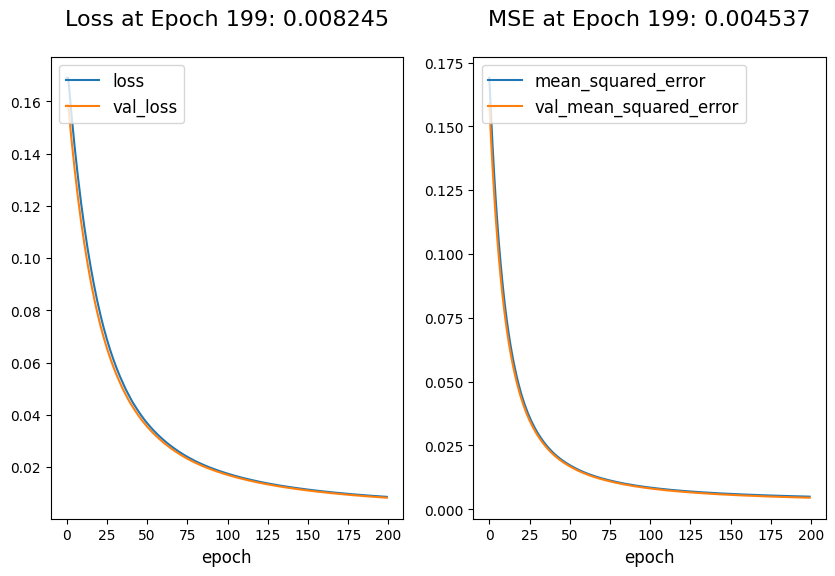

> training time is 1.8892 minutes
Train id: 7


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 7)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

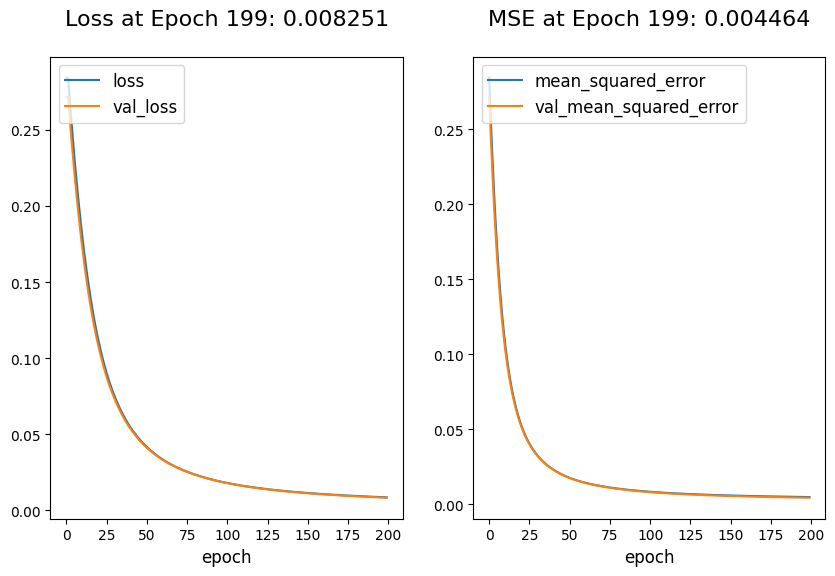

> training time is 2.0860 minutes
Train id: 8


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

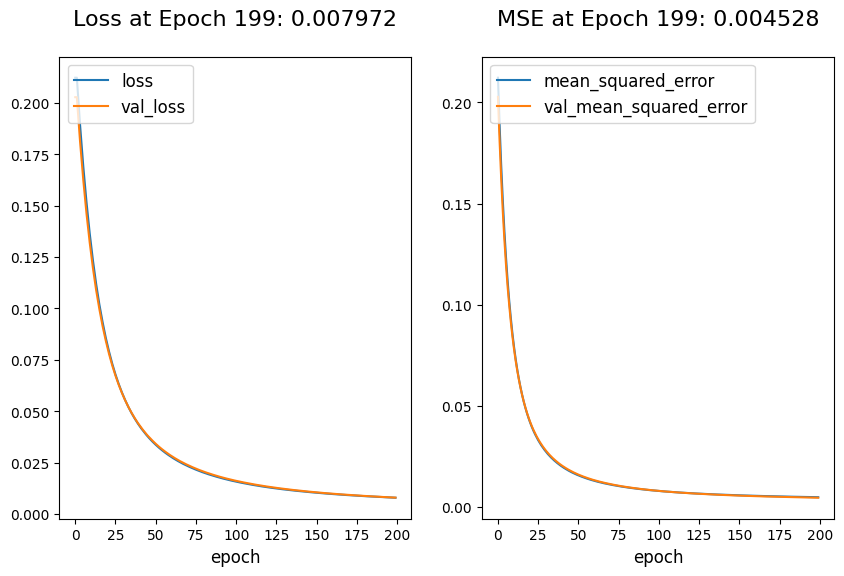

> training time is 2.0734 minutes
Train id: 9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 9)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

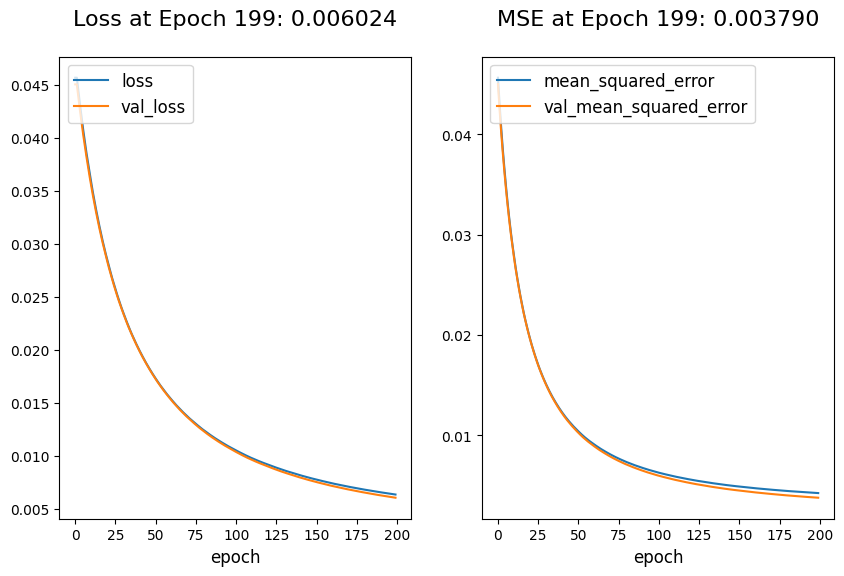

> training time is 2.3936 minutes
Train id: 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

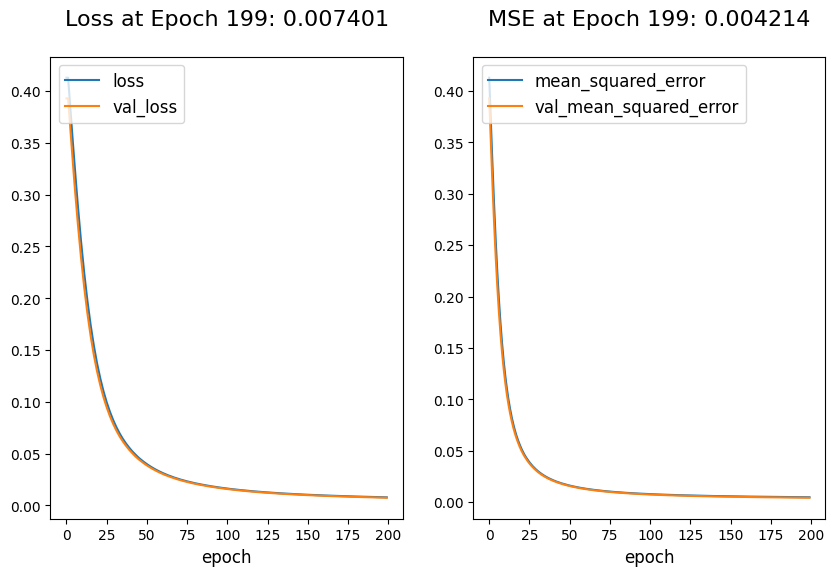

> training time is 2.2135 minutes


In [162]:
history = []
for i in range(1, 11, 1):
    print(f"Train id: {i}")
    temp_history = train_model(i, x_exp3_train, y_exp3_train, x_exp3_valid, y_exp3_valid, n_hidden=i, nb_epochs = 200)
    history.append(temp_history)
# for

### 6.4. Evaluating

In [163]:
errors = []
for i in range(len(history)):
    epoch_opt = np.argmin(history[i].history["val_mean_squared_error"])
    error = history[i].history["val_mean_squared_error"][epoch_opt]
    errors.append(error)
# for
hiddens = list(range(1, 11, 1))

In [166]:
vt_min = np.argmin(np.array(errors))
print(f"Min Error at n_hidden={hiddens[vt_min]} with error = {errors[vt_min]}")

Min Error at n_hidden=10 with error = 0.003845316357910633


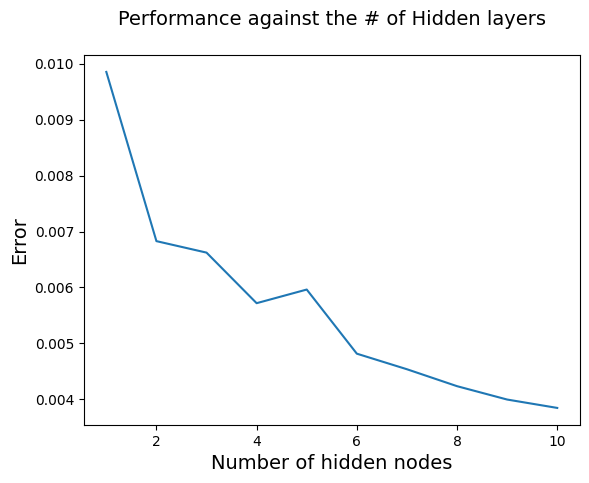

In [167]:
plt.plot(hiddens, errors)
plt.xlabel("Number of hidden nodes", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.title("Performance against the # of Hidden layers\n", fontsize = 14);

### 6.5. Discussion

| Cấu hình | Hidden Layers | Accuracy | Nhận xét |
|----------|---------------|----------|----------|
| 1 | 1| 0.003845316357910633 | Mạng nông với một hidden layer cho kết quả tốt hơn so với mạng sâu hơn. Có thể phù hợp với dữ liệu đơn giản. |
| 2 | 2 | 0.002588044386357069 | Khi thêm một hidden layer, độ chính xác giảm. Cần kiểm tra regularization và learning rate. |
| 3 | 3 | 0.0024122423492372036 | Mạng bắt đầu trở nên phức tạp, có thể gặp vấn đề gradient vanishing hoặc overfitting. |
| 4 | 4 | 0.0022784415632486343 | Hiệu suất tiếp tục giảm, mạng có thể quá phức tạp cho dữ liệu hiện tại. Cần áp dụng Batch Normalization hoặc Dropout.|
| 5 | 5 | 0.0022755861282348633| Tăng số hidden layers không cải thiện hiệu suất. Có thể dữ liệu đầu vào không phù hợp với mạng sâu.|

- Dữ liệu đơn giản: Với chỉ 2 đặc trưng, mạng nông (1-2 hidden layers) phù hợp hơn.
- Giảm hiệu suất: Số hidden layers tăng nhưng accuracy giảm, do mạng bị overfitting hoặc tối ưu hóa chưa tốt.